*ChatGPT-4 used throughout to generate code snippets*

# Setup

## Install libraries

geopandas, fastparquet, numpy

In [1]:
# in jupyter notebooks, normal install using !pip install doesn't work, use the solution from:
# https://www.geeksforgeeks.org/install-python-package-using-jupyter-notebook/

import sys
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install geopandas
!{sys.executable} -m pip install fastparquet
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install tempun

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import fastparquet
import tempun

## Import LIRE_v2.3 dataset 

**Source**: https://zenodo.org/record/8147298

**Format**: parquet

In [3]:
lire = gpd.read_parquet('data/LIRE_v2-3.parquet')

### Display first five rows of LIRE dataset

In [4]:
lire.head(5)

,LIST-ID,EDCS-ID,EDH-ID,trismegistos_uri,pleiades_id,transcription,inscription,clean_text_conservative,clean_text_interpretive_sentence,clean_text_interpretive_word,...,not_before,Longitude,Latitude,geotemporal?,geometry,urban_context,urban_context_city,urban_context_pop_est,type_of_inscription_auto,type_of_inscription_auto_prob
445464,445465,EDCS-03700724,HD052964,https://www.trismegistos.org/text/121715,531064,Fortissimo et piis/simo Caesari d(omino) n(ost...,Fortissimo et Piis/simo Caesari d(omino) n(ost...,Fortissimo et piissimo Caesari d n Gal Val P F...,Fortissimo et piissimo Caesari domino nostro G...,Fortissimo et piissimo Caesari domino nostro G...,...,309.0,20.766800,39.451200,True,POINT (20.767 39.451),rural,None,NaN,honorific inscription,1.0
445466,445467,EDCS-03300852,HD051000,https://www.trismegistos.org/text/177273,240855,[Imp(eratori) Caes(ari) M(arco)] / An[nio] Flo...,Imp(eratori) / Floriano / P(io) F(elici) Aug(u...,An Floriano P F Aug p p m p III Imp Caes M Aur...,Imperatori Caesari Marco Annio Floriano Pio Fe...,Imperatori Caesari Marco Annio Floriano Pio Fe...,...,276.0,22.417100,37.431900,True,POINT (22.417 37.432),large,Tegea,46362.0,mile-/leaguestone,1.0
445467,445468,EDCS-28500283,HD021396,https://www.trismegistos.org/text/177131,,T[i(berius)] Claudius Caesar Aug(ustus) / G[er...,T[(iberius)] Claudius Caesar Aug(ustus) / G[er...,T Claudius Caesar Aug Ganicus pontif max trib ...,Tiberius Claudius Caesar Augustus Germanicus p...,Tiberius Claudius Caesar Augustus Germanicus p...,...,49.0,22.420877,37.454501,True,POINT (22.421 37.455),large,Tegea,46362.0,public legal inscription,1.0
445469,445470,EDCS-09400671,HD011892,https://www.trismegistos.org/text/177087,,Pro salute Imp(eratorum) Caesari(s) / L(uci) S...,Pro salute Imp(eratoris) Caesari(s) / L(uci) S...,Pro salute Imp Caesari L Septimi Severi et M A...,Pro salute Imperatorum Caesaris Luci Septimi S...,Pro salute Imperatorum Caesaris Luci Septimi S...,...,198.0,24.937637,37.837612,True,POINT (24.938 37.838),rural,None,NaN,votive inscription,1.0
445471,445472,EDCS-24600769,HD050999,https://www.trismegistos.org/text/177272,570531,Octa(vius) Sal(utaris),Octa(vius) Sa(lutaris),Octa Sal,Octavius Salutaris,Octavius Salutaris,...,81.0,21.627100,37.647900,True,POINT (21.627 37.648),rural,None,NaN,owner/artist inscription,1.0


### Print column names

Also set column names as a variable so that it can be used later

In [5]:
lire_columns = lire.columns
print("\n".join(lire_columns))

LIST-ID
EDCS-ID
EDH-ID
trismegistos_uri
pleiades_id
transcription
inscription
clean_text_conservative
clean_text_interpretive_sentence
clean_text_interpretive_word
clean_text_interpretive_word_EDCS
diplomatic_text
province
place
inscr_type
status_notation
inscr_process
status
partner_link
last_update
letter_size
type_of_inscription
work_status
year_of_find
present_location
text_edition
support_objecttype
support_material
support_decoration
keywords_term
people
type_of_inscription_clean
type_of_inscription_certainty
height_cm
width_cm
depth_cm
material_clean
type_of_monument_clean
type_of_monument_certainty
province_label_clean
province_label_certainty
country_clean
country_certainty
findspot_ancient_clean
findspot_ancient_certainty
modern_region_clean
modern_region_certainty
findspot_modern_clean
findspot_modern_certainty
findspot_clean
findspot_certainty
language
language_EDCS
raw_dating
not_after
not_before
Longitude
Latitude
geotemporal?
geometry
urban_context
urban_context_city
urb

# Clean data

The quality of the dataset is pretty good, but I found some errors where the date range is negative. Vojtech suggests reversing the dates.

Find rows where 'not_before' is greater than 'not_after'

In [6]:
error_rows = lire[lire['not_before'] > lire['not_after']]

Swap the 'not_before' and 'not_after' values

In [7]:
# Define a function to swap 'not_before' and 'not_after' when 'not_before' > 'not_after'
def swap_dates(row):
    if row['not_before'] > row['not_after']:
        row['not_before'], row['not_after'] = row['not_after'], row['not_before']
    return row

# Apply the function to swap the dates
lire = lire.apply(swap_dates, axis=1)

# Overview: SPA of the entire LIRE dataset

## All inscriptions, uniform distribution between start and end dates, disregard locations

Define the resolution for the summed probability distribution

*Resolution must be defined because this dataset is formatted 'float' and not 'interger'. Resolution defines the size of bins or segments in years*.

In [8]:
resolution = 10

Initialize the summed probability distribution

In [9]:
earliest_date = lire['not_before'].min()
latest_date = lire['not_after'].max()

Creat an array of zeros to hold the summed probabilities

In [10]:
num_bins = int((latest_date - earliest_date) / resolution) + 1
summed_prob = np.zeros(num_bins)

Loop through each inscription to update the summed probability distribution


In [11]:
for index, row in lire.iterrows():
    start = row['not_before']
    end = row['not_after']
    
    start_idx = int((start - earliest_date) / resolution)
    end_idx = int((end - earliest_date) / resolution)
   
    # Calculate uniform distribution for this inscription,
    # accounting for date combinations that add up to zero
    try:
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
    except ZeroDivisionError:
        uniform_prob = 1  # set default value here

    # Add this distribution to the overall summed distribution
    summed_prob[start_idx : end_idx + 1] += uniform_prob

Plot the summed probability distribution

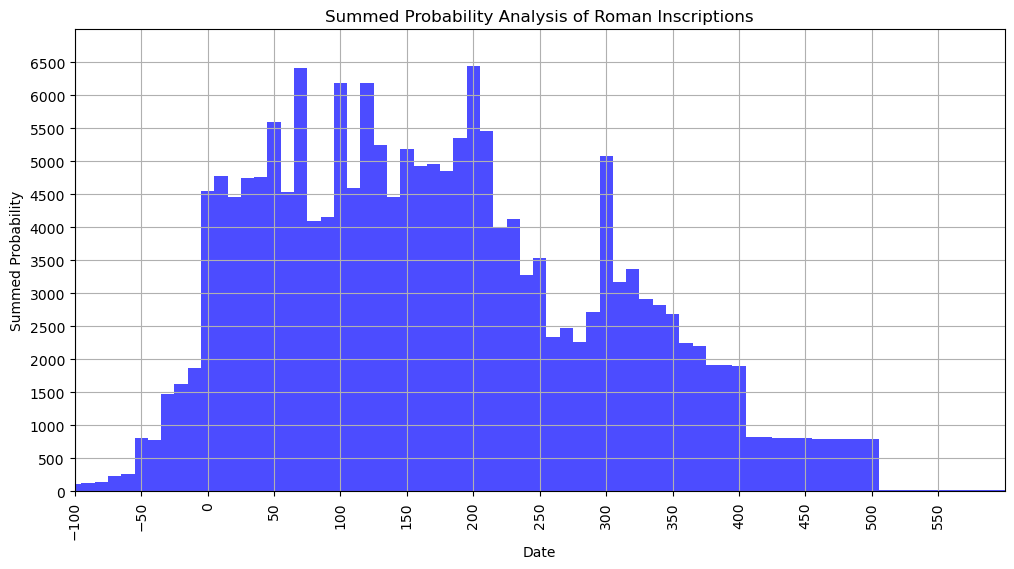

In [12]:
# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(np.arange(earliest_date, latest_date + resolution, resolution), summed_prob, width=resolution, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Summed Probability')
plt.title('Summed Probability Analysis of Roman Inscriptions')

# set axis limits and grid
plt.xlim([-100, 600])
plt.ylim([0, 7000])
plt.grid(True)
plt.xticks(np.arange(-100, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 7000, 500))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

Looking at this overview plot:

* Several of the peaks seem to correspond to dynasty changes.
* Start date should probably be 1 AD
* End date should probably be 400 AD

# Understanding uncertainty: date range statistics

Calculate date range for each inscription and add it to the DF

In [13]:
lire['date_range'] = lire['not_after'] - lire['not_before']

### Calculate descriptive statistics

In [14]:
# Return the total number of records

total_records = lire.shape[0]

# Calculate the average date range
average_range = lire['date_range'].mean()

# Calculate the median date range
median_range = lire['date_range'].median()

# Calculate the standard deviation of the date range
std_dev_range = lire['date_range'].std()

print(f"Total number of records: {total_records}")
print(f"Average Date Range: {average_range}")
print(f"Median Date Range: {median_range}")
print(f"Standard Deviation of Date Range: {std_dev_range}")

Total number of records: 182852
Average Date Range: 101.28705182333253
Median Date Range: 99.0
Standard Deviation of Date Range: 76.75115026800985


### Create a histogram of date ranges

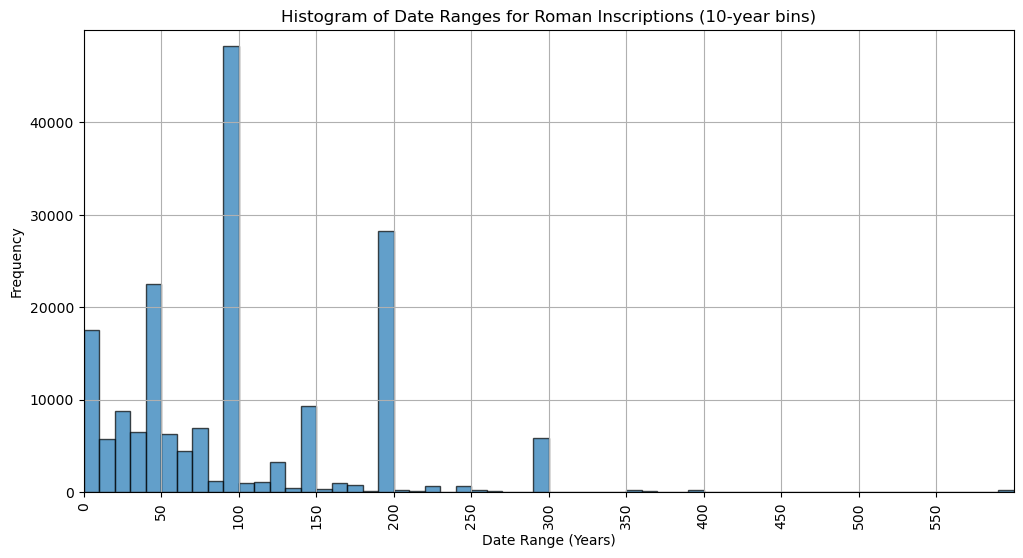

In [15]:
# Create the histogram
plt.figure(figsize=(12, 6))
plt.hist(lire['date_range'], bins=np.arange(0, lire['date_range'].max() + 10, 10), edgecolor='black', alpha=0.7)

# Add labels and title
plt.xlabel('Date Range (Years)')
plt.ylabel('Frequency')
plt.title('Histogram of Date Ranges for Roman Inscriptions (10-year bins)')

# set axis limits and grid
plt.xlim([0, 600])
plt.ylim([0, 50000])
plt.grid(True)
plt.xticks(np.arange(0, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 50000, 10000))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

### Count number of inscriptions *between* various date-range thresholds

300, 200, 100, 50, 25, 10, and 1 year / exact date thresholds

In [16]:
# Define the thresholds

thresholds = [1, 10, 25, 50, 100, 200, 300] 

# Create bins using the thresholds
bins = [0] + thresholds + [lire['date_range'].max() + 1]

# Categorize the date ranges based on the bins
lire['date_range_bins'] = pd.cut(lire['date_range'], bins, right=False) # Count is right-exclusive

# Count the number of inscriptions in each bin
inscription_counts = lire['date_range_bins'].value_counts().sort_index()

# Display the counts
print("Counts of inscriptions with date ranges between certain thresholds:")
print(inscription_counts)

# As a check, count the number of inscriptions with a '0' date range 
# (date reanges should not be less that one year)

print("Specific counts for cross-checking")
zero_date_range_count = len(lire[lire['date_range'] == 0])
print(f"Number of records with a date range of 0: {zero_date_range_count}")
lessthanone_date_range_count = len(lire[lire['date_range'] < 1])
print(f"Number of records with a date range of < 1: {lessthanone_date_range_count}")
oneorless_date_range_count = len(lire[lire['date_range'] <= 1])
print(f"Number of records with a date range of <= 1: {oneorless_date_range_count}")
lessthanzero_date_range_count = len(lire[lire['date_range'] < 0])
print(f"Number of records with a date range less than 0: {lessthanzero_date_range_count}")


Counts of inscriptions with date ranges between certain thresholds:
[0.0, 1.0)          8279
[1.0, 10.0)         9296
[10.0, 25.0)        8415
[25.0, 50.0)       35122
[50.0, 100.0)      67162
[100.0, 200.0)     45651
[200.0, 300.0)      7995
[300.0, 2060.0)      932
Name: date_range_bins, dtype: int64
Specific counts for cross-checking
Number of records with a date range of 0: 8279
Number of records with a date range of < 1: 8279
Number of records with a date range of <= 1: 11069
Number of records with a date range less than 0: 0


### Identify records with a date range less than zero

#### *Records have now been cleaned above to resolve the problem of negative date ranges*.

In [17]:
# Filter records where date_range is less than 0
records_with_negative_date_range = lire[lire['date_range'] < 0]

# Display only specific columns for the filtered records
print(records_with_negative_date_range[['LIST-ID', 'raw_dating', 'not_before', 'not_after', 'date_range']])

records_with_negative_date_range.to_csv("records_with_negative_date_range", index=False)

Empty DataFrame
Columns: [LIST-ID, raw_dating, not_before, not_after, date_range]
Index: []


### Count number of inscriptions with date ranges *under* various thresholds

In [18]:
# Define the thresholds
thresholds = [1, 10, 25, 50, 100, 200, 300]

# Initialize an empty dictionary to store counts
cumulative_counts = {}

# Calculate counts for each threshold
for threshold in thresholds:
    count = len(lire[lire['date_range'] < threshold]) # counts are right-exclusive
    cumulative_counts[threshold] = count

# Display the counts
print("Cumulative counts of inscriptions with date ranges under various thresholds:")
for threshold, count in cumulative_counts.items():
    print(f"0-{threshold} years: {count}")

Cumulative counts of inscriptions with date ranges under various thresholds:
0-1 years: 8279
0-10 years: 17575
0-25 years: 25990
0-50 years: 61112
0-100 years: 128274
0-200 years: 173925
0-300 years: 181920


# SPA on subsets of data with narrower date ranges

## 100 years or less (trial)

Filter dataset to include only inscriptions with a date range of 100 years or less

In [19]:
filtered_lire = lire[lire['date_range'] <= 100]

Run the SPA as above, but on the filtered dataset

In [20]:
# Define the resolution for the summed probability distribution
resolution = 10

# Initialize the summed probability distribution
earliest_date = filtered_lire['not_before'].min()
latest_date = filtered_lire['not_after'].max()

# Create an array of zeros to hold the summed probabilities
num_bins = int((latest_date - earliest_date) / resolution) + 1
summed_prob = np.zeros(num_bins)

# Loop through each inscription to update the summed probability distribution
for index, row in filtered_lire.iterrows():
    start = row['not_before']
    end = row['not_after']
    
    start_idx = int((start - earliest_date) / resolution)
    end_idx = int((end - earliest_date) / resolution)
    
    # Handle the zero-division case
    try:
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
    except ZeroDivisionError:
        uniform_prob = 1  # or another default value

    # Add this distribution to the overall summed distribution
    summed_prob[start_idx : end_idx + 1] += uniform_prob


Plot the summed probability distribution

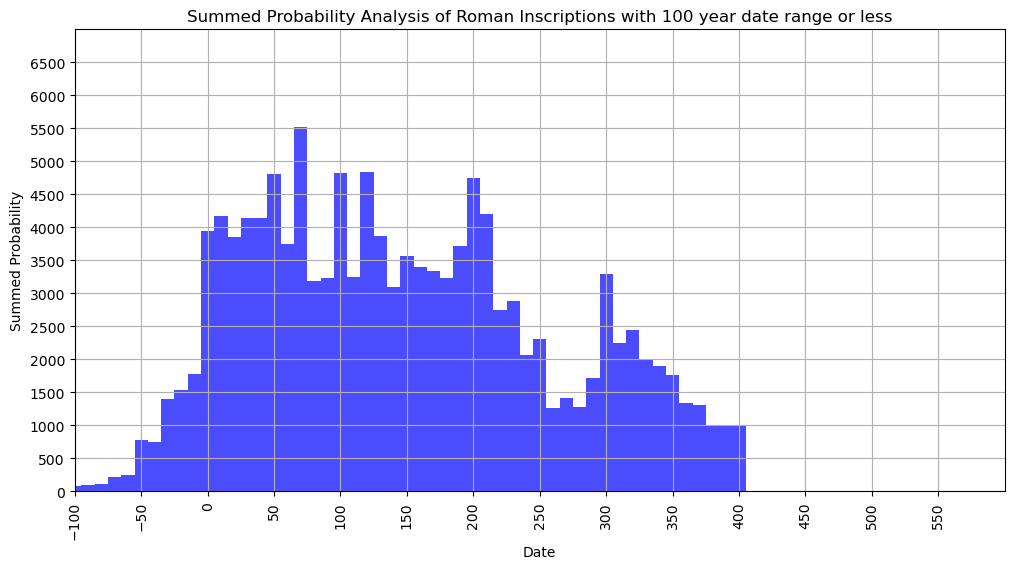

In [21]:
# Recalculate x_values to match summed_prob to avoid a ValueError: shape mismatch between them
x_values = np.arange(earliest_date, earliest_date + resolution*num_bins, resolution)

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.7)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Summed Probability')
plt.title('Summed Probability Analysis of Roman Inscriptions with 100 year date range or less')

# set axis limits and grid
plt.xlim([-100, 600])
plt.ylim([0, 7000])
plt.grid(True)
plt.xticks(np.arange(-100, 600, 50), rotation='vertical')  # Change 10 to the desired tick interval for the x-axis
plt.yticks(np.arange(0, 7000, 500))  # Change 500 to the desired tick interval for the y-axis

# Show the plot
plt.show()

## SPA *between* various thresholds

0-1; 1-10; 10-25; 25-50; 50-100; 100-200; 200-300 right exclusive

Compute summed probability distribution

In [48]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=25):  # Changed from 10 to 25
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)

    for _, row in df.iterrows():
        start_idx = int((row['not_before'] - earliest_date) / resolution)
        end_idx = int((row['not_after'] - earliest_date) / resolution)

        # Skip if start_idx or end_idx is out of range
        if start_idx >= num_bins or end_idx < 0:
            continue

        # Clip indices to be within valid range
        start_idx = max(start_idx, 0)
        end_idx = min(end_idx, num_bins - 1)

        # Calculate uniform probability for the date range
        if end_idx - start_idx > 0:
            uniform_prob = 1.0 / (end_idx - start_idx + 1)
        else:
            uniform_prob = 1.0

        summed_prob[start_idx:end_idx + 1] += uniform_prob

    return summed_prob


Define thresholds for date ranges and create plots

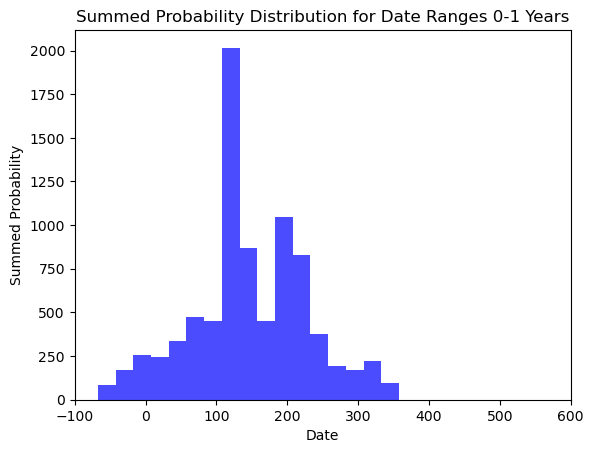

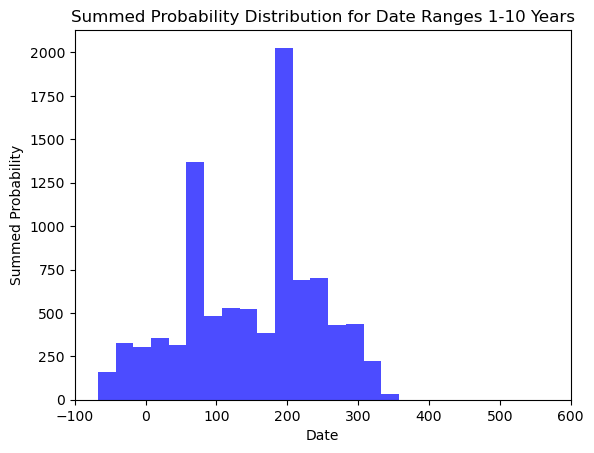

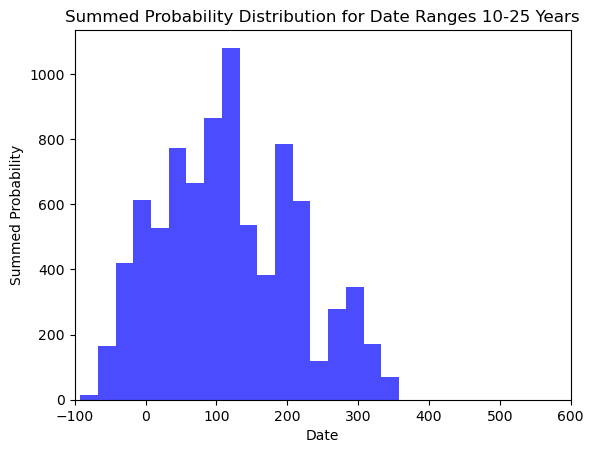

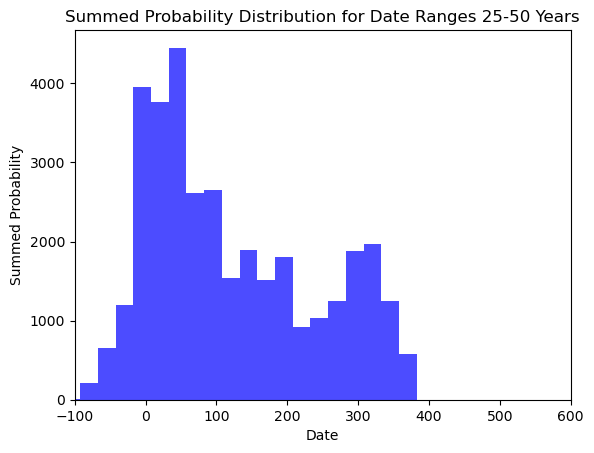

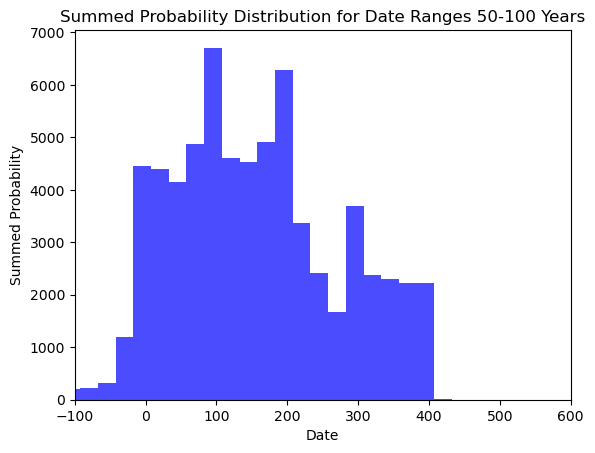

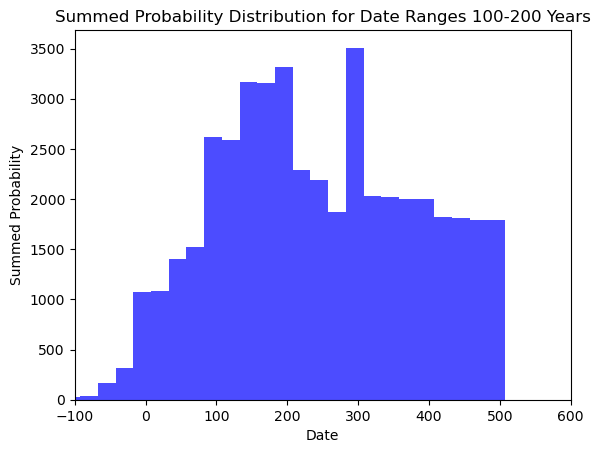

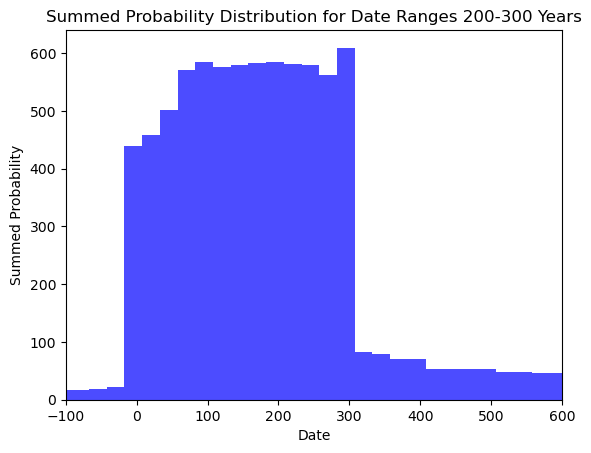

In [50]:
# Create a column for date ranges
lire['date_range'] = lire['not_after'] - lire['not_before']

# Define date range thresholds
thresholds = [
    (0, 1),
    (1, 10),
    (10, 25),
    (25, 50),
    (50, 100),
    (100, 200),
    (200, 300),
]

# Determine the earliest and latest dates for the axis
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Create a plot for each threshold
for start, end in thresholds:
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Set the resolution to 25 years
    summed_prob = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=25)  

    plt.figure()
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    
    # Changed width and step size in np.arange to 25
    plt.bar(np.arange(earliest_date, latest_date, 25), summed_prob, width=25, color='blue', alpha=0.7)  
    plt.xlim([-100, 600])
    plt.xlabel('Date')
    plt.ylabel('Summed Probability')
    plt.show()

### SPA for dates *below* certain thresholds

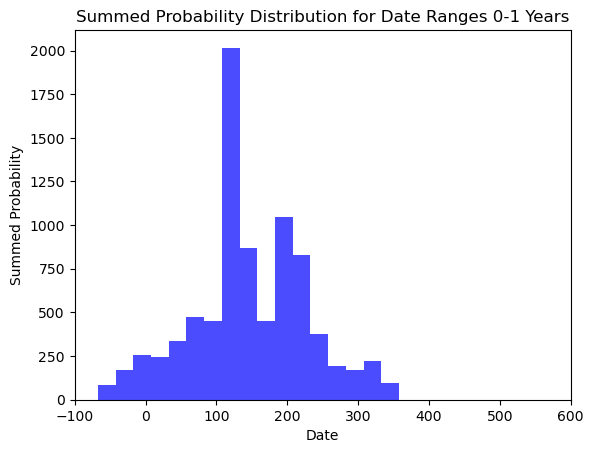

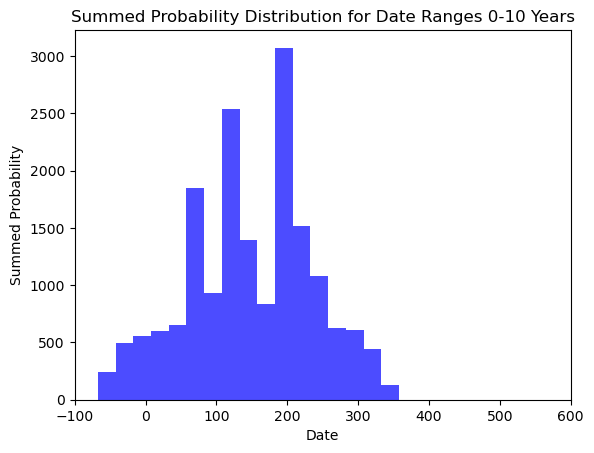

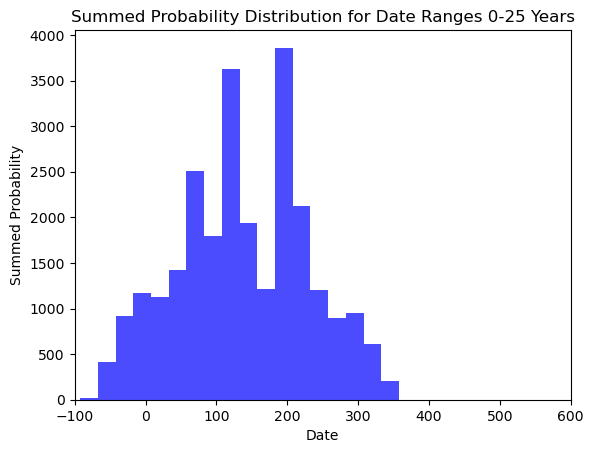

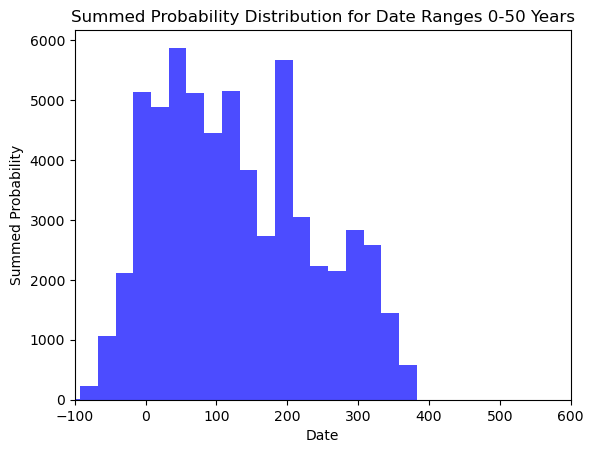

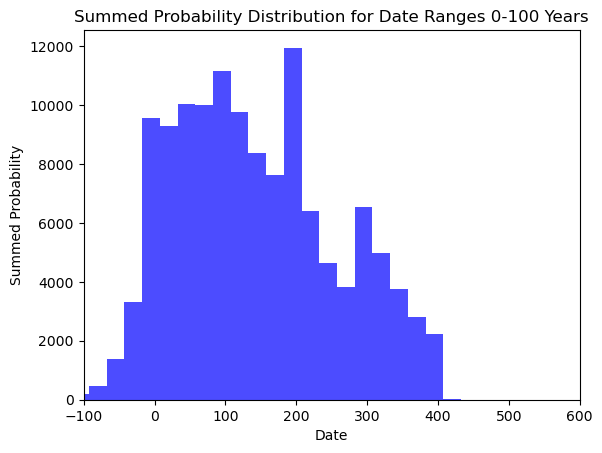

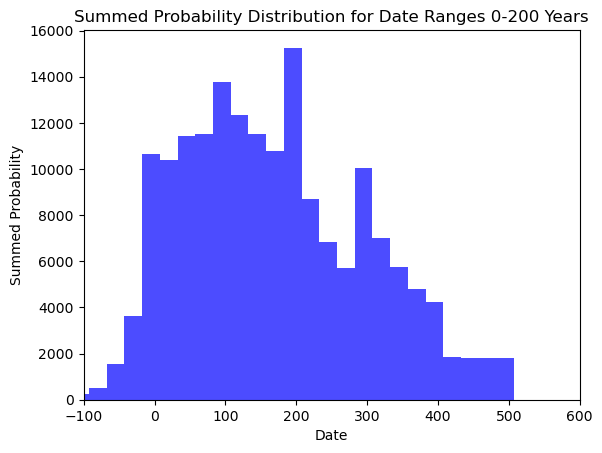

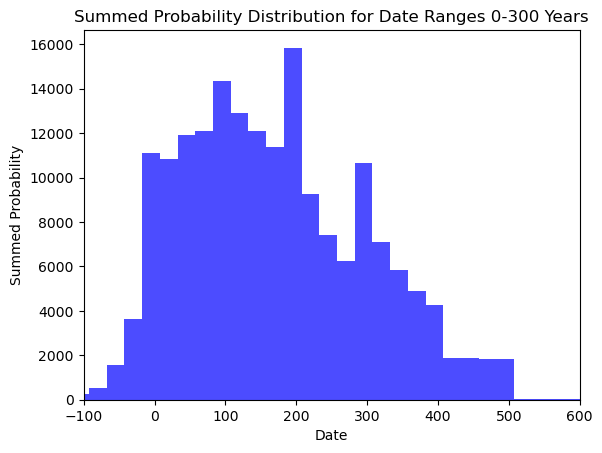

In [52]:
# Create a column for date ranges
lire['date_range'] = lire['not_after'] - lire['not_before']

# Define date range thresholds
thresholds = [
    (0, 1),
    (0, 10),
    (0, 25),
    (0, 50),
    (0, 100),
    (0, 200),
    (0, 300),
]

# Determine the earliest and latest dates for the axis
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())
remainder = (latest_date - earliest_date) % 25
latest_date_adjusted = latest_date + (25 - remainder)


# Create a plot for each threshold
for start, end in thresholds:
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Set the resolution to 25 years
    summed_prob = compute_summed_probability(subset_df, earliest_date, latest_date_adjusted, resolution=25)  

    plt.figure()
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    
    # Changed width and step size in np.arange to 25
    plt.bar(np.arange(earliest_date, latest_date_adjusted, 25), summed_prob, width=25, color='blue', alpha=0.7)  
    plt.xlim([-100, 600])
    plt.xlabel('Date')
    plt.ylabel('Summed Probability')
    plt.show()

## SPA *between* various thresholds with error margins

Error bars indicate standard deviation for each bin

### Compute summed probability and error

In [58]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=10):
    """Calculate summed probability distribution.
    
    Parameters:
    - df: DataFrame containing the inscriptions data.
    - earliest_date, latest_date: Time range for analysis.
    - resolution: Bin size for grouping dates.
    
    Returns:
    - summed_prob: Array of summed probabilities.
    - std_devs: Array of standard deviations.
    """
    
    # Calculate the number of bins
    num_bins = int((latest_date - earliest_date) / resolution)
    
    # Initialize arrays to hold summed probabilities and standard deviations
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        # Calculate the start and end indices for the date range of this inscription
        start_idx = int((row['not_before'] - earliest_date) / resolution)
        end_idx = int((row['not_after'] - earliest_date) / resolution)
        
        # Avoid IndexError by ensuring indices are within bounds
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for this date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1)
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            # Calculate the binomial variance for the bin (for later calculation of std. dev.)
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
    
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

### Plot SPA with error margins

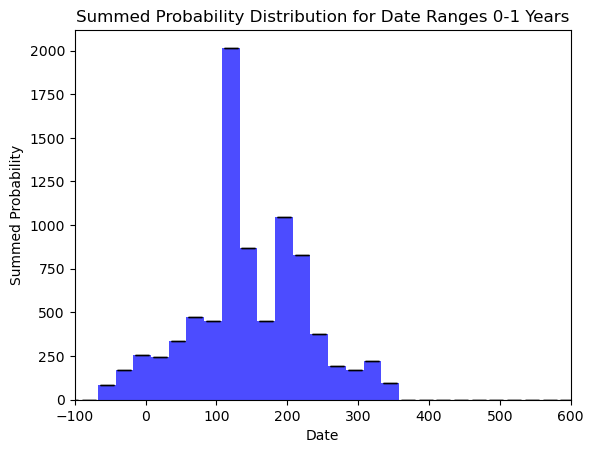

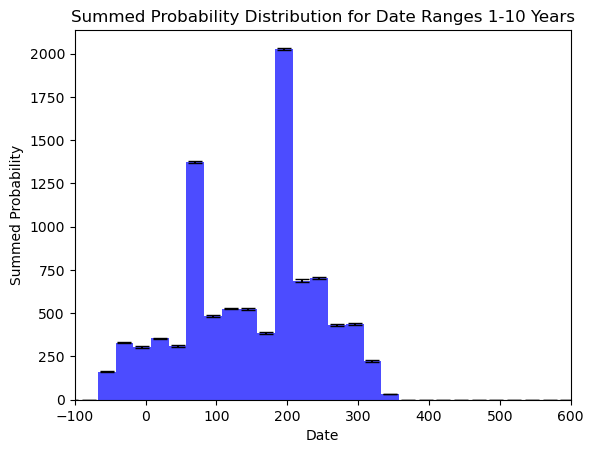

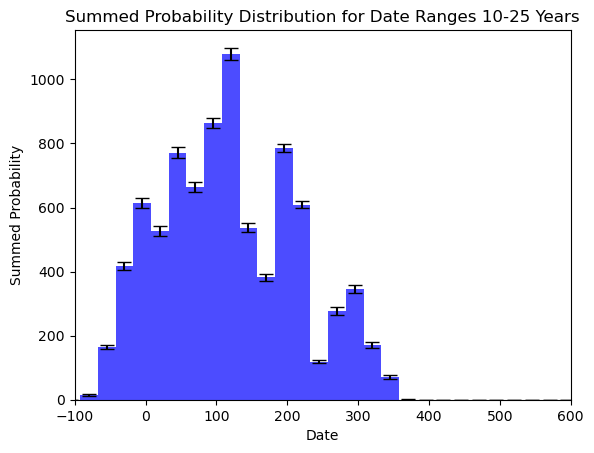

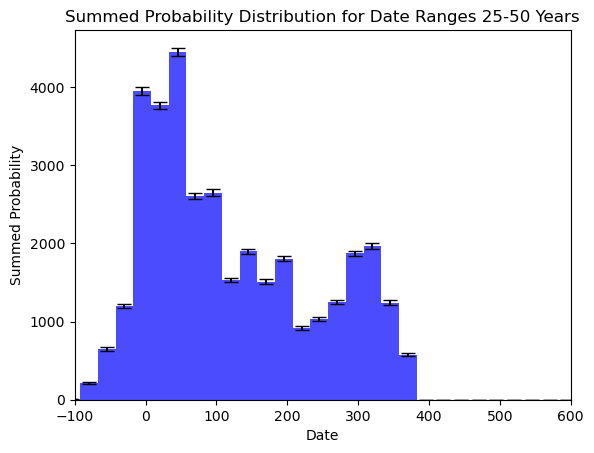

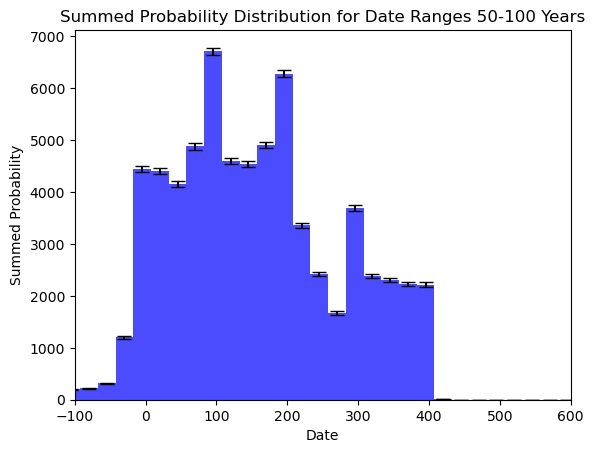

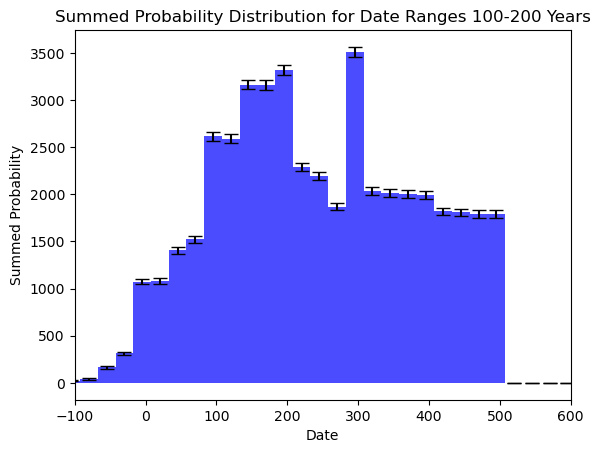

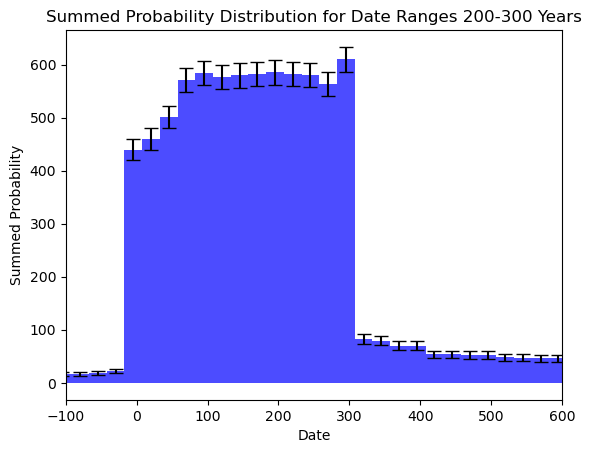

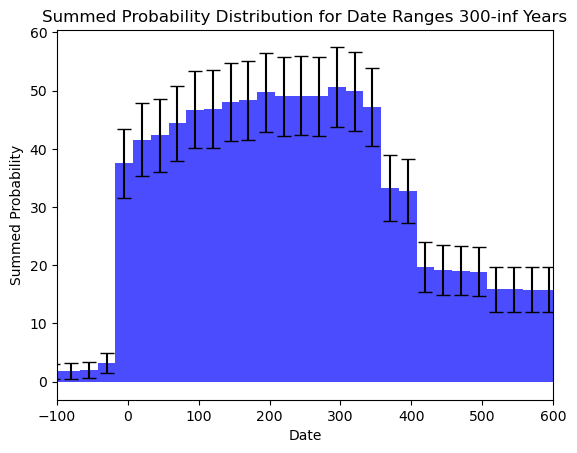

In [59]:
# Define your thresholds for date ranges
thresholds = [(0, 1), (1, 10), (10, 25), (25, 50), (50, 100), (100, 200), (200, 300), (300, float('inf'))]

# Determine the earliest and latest possible dates
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Loop through each threshold and plot the corresponding summed probability
for start, end in thresholds:
    # Filter the data to only include rows within the current threshold
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=25)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, 25)[:len(summed_prob)]
    
    # Create a new figure for the plot
    plt.figure()
    
    # Set the title and labels
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    
    # Create the bar chart with error bars
    plt.bar(x_values, summed_prob, yerr=std_devs, width=25, color='blue', alpha=0.7, capsize=5)
    
    # Show the plot
    plt.show()


## SPA plots *under* various thresholds with error margins

### Compute summed probability and error

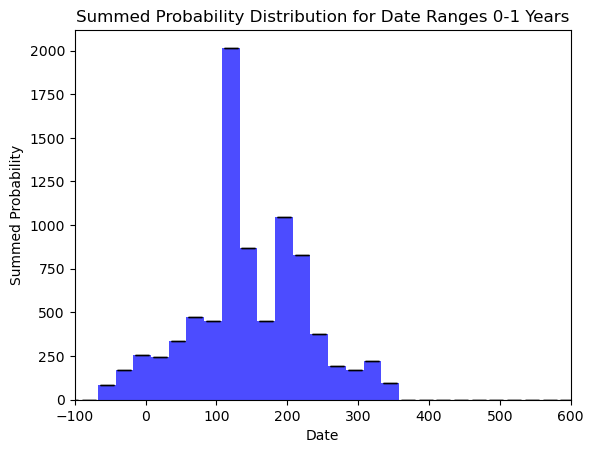

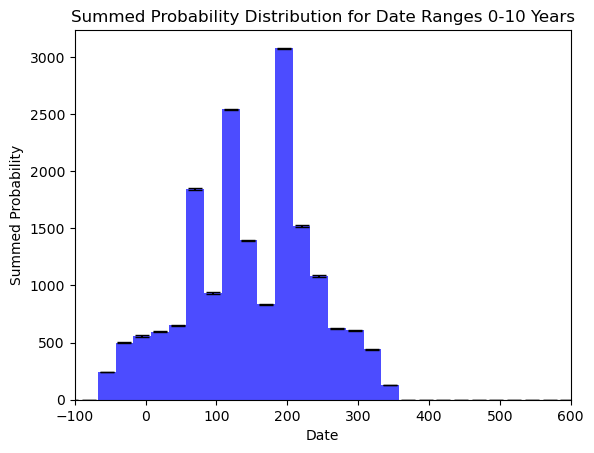

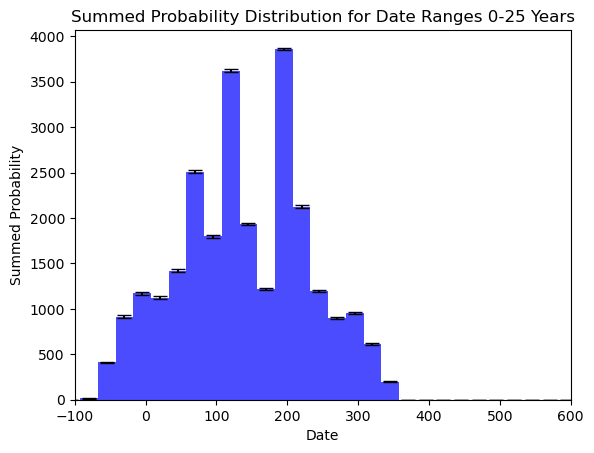

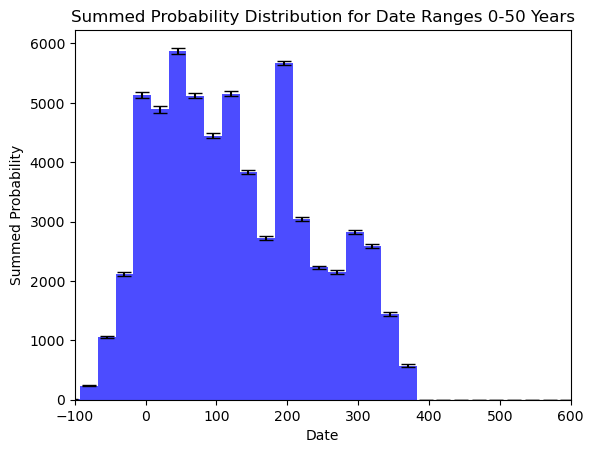

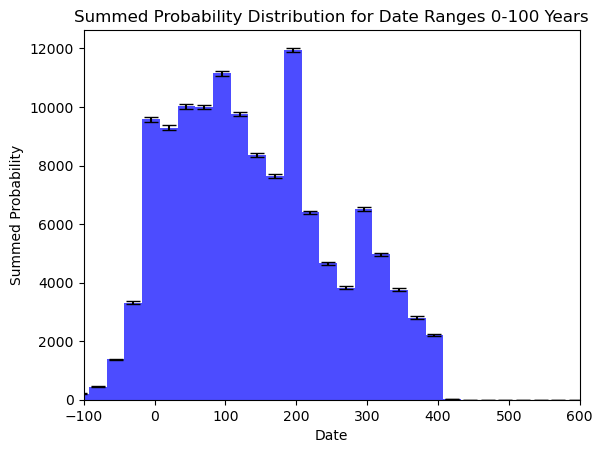

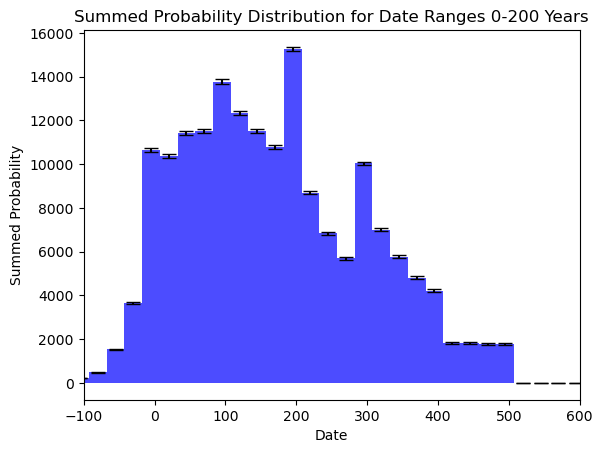

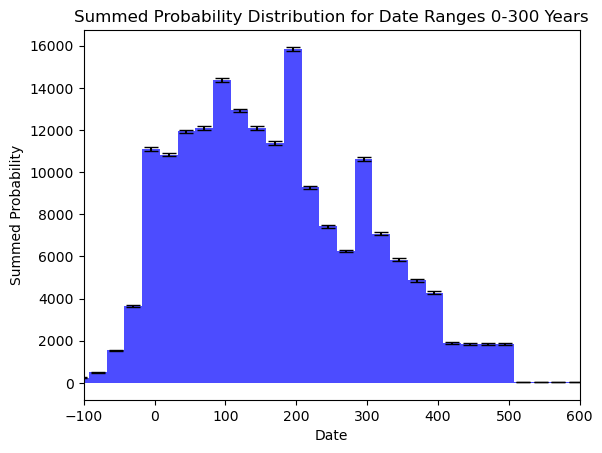

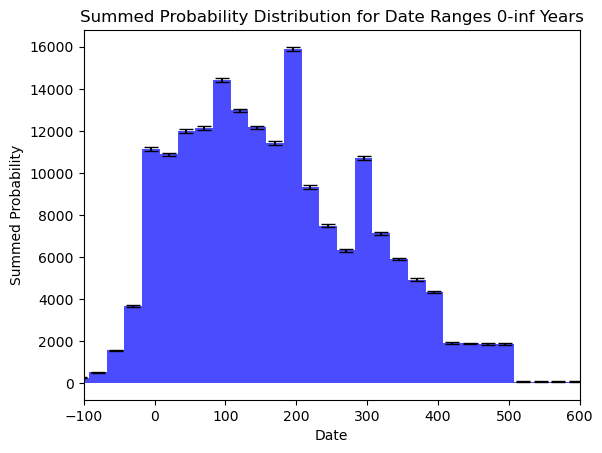

In [60]:
# Define your thresholds for date ranges
thresholds = [(0, 1), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]

# Determine the earliest and latest possible dates
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Loop through each threshold and plot the corresponding summed probability
for start, end in thresholds:
    # Filter the data to only include rows within the current threshold
    subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] < end)]
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=25)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, 25)[:len(summed_prob)]
    
    # Create a new figure for the plot
    plt.figure()
    
    # Set the title and labels
    plt.title(f'Summed Probability Distribution for Date Ranges {start}-{end} Years')
    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    
    # Create the bar chart with error bars
    plt.bar(x_values, summed_prob, yerr=std_devs, width=25, color='blue', alpha=0.7, capsize=5)
    
    # Show the plot
    plt.show()


## SPA plots *under* various thresholds with trend line and error margins

### Compute and plot summed probability, trend line points, and error margins

#### Full dataset

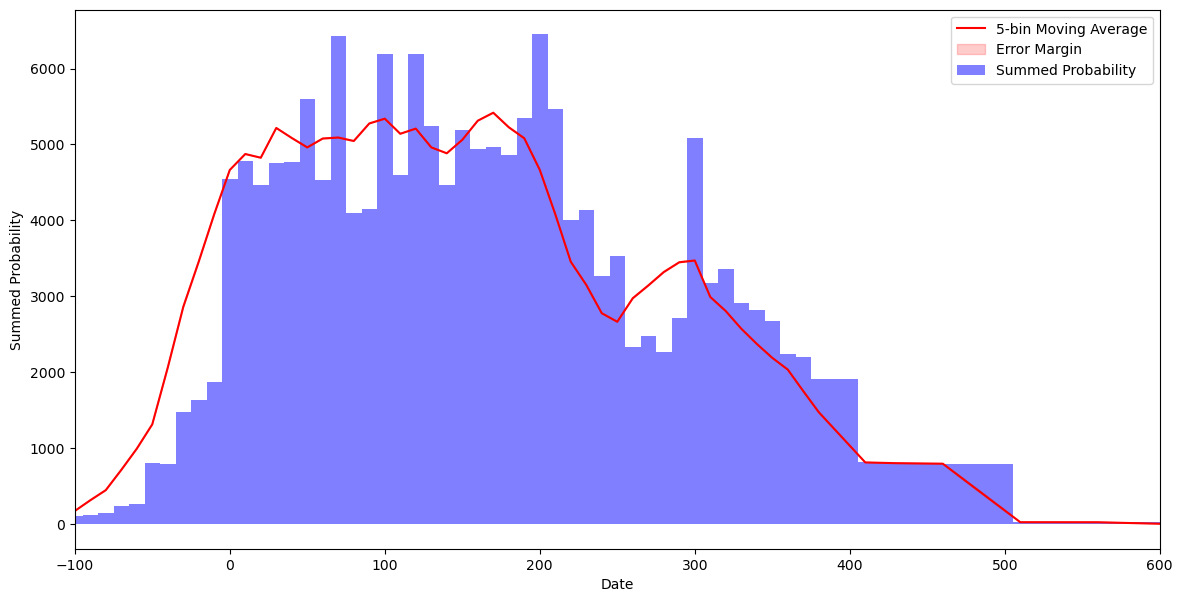

In [75]:
def moving_average(data, window_size):
    """Calculate the moving average of a 1D array."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def moving_std(data, window_size):
    """Calculate the moving standard deviation of a 1D array."""
    return np.array([np.std(data[i:i+window_size]) for i in range(len(data) - window_size + 1)])

# Data preparation
earliest_date = int(lire['not_before'].min())
latest_date = int(lire['not_after'].max())

# Choose your bin resolution and window size for moving average
resolution = 10 # Bin resolution
window_size = 5 # Number of bins being averaged; multiply by resolution to get the moving average in years

# Compute summed probability and standard deviations
summed_prob, std_devs = compute_summed_probability(lire, earliest_date, latest_date, resolution=resolution)

# Generate x-values for plotting
x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]

# Calculate the moving average and moving standard deviation
avg_moving = moving_average(summed_prob, window_size)
std_moving = moving_std(std_devs, window_size)

# Generate x-values for the moving average (it will be shorter due to the window size)
x_moving = x_values[:len(avg_moving)]

# Plotting
plt.figure(figsize=(14, 7))
plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
plt.plot(x_moving, avg_moving, color='red', label=f'{window_size}-bin Moving Average')
plt.fill_between(x_moving, avg_moving-std_moving, avg_moving+std_moving, color='red', alpha=0.2, label='Error Margin')
plt.xlabel('Date')
plt.xlim([-100, 600])
plt.ylabel('Summed Probability')
plt.legend()
plt.show()


#### *Between* various thresholds

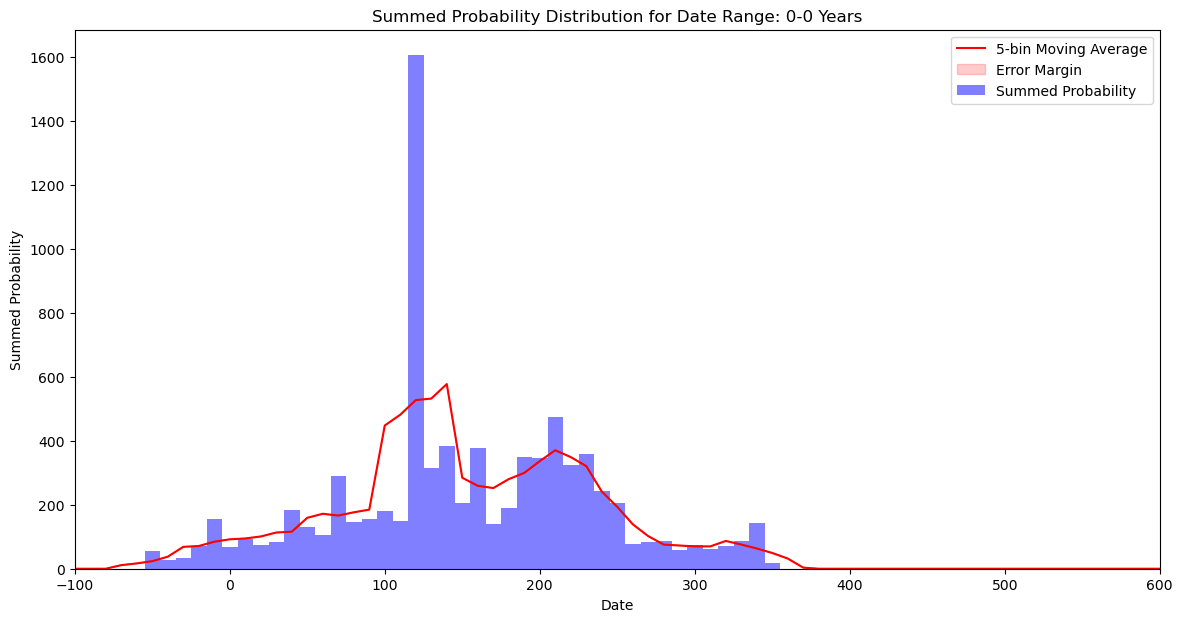

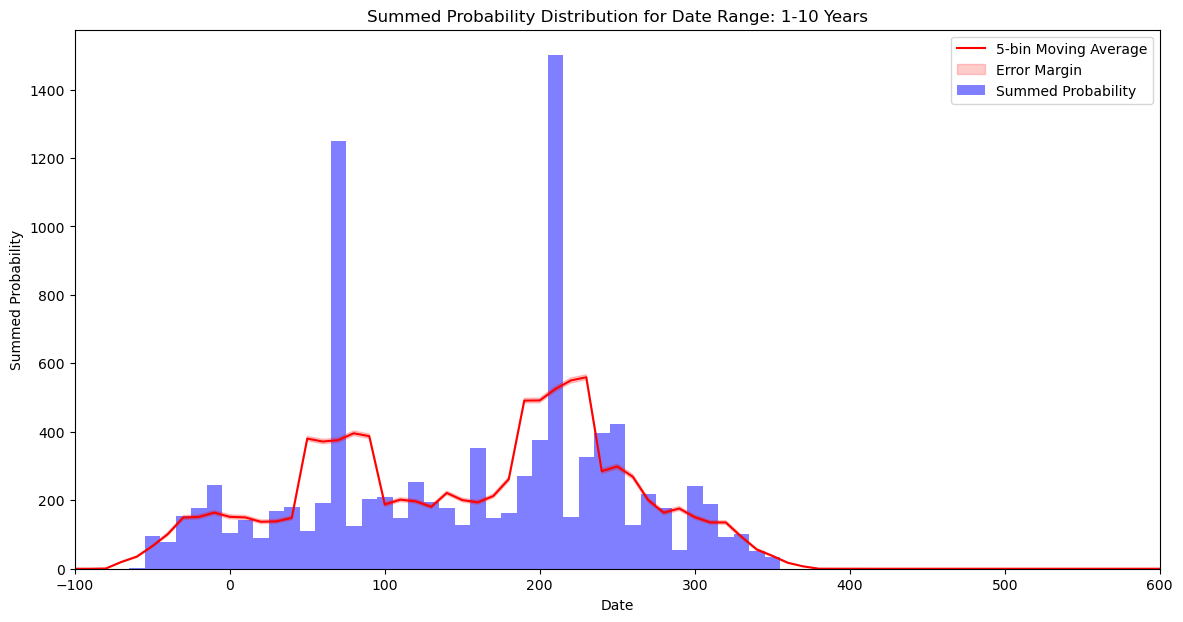

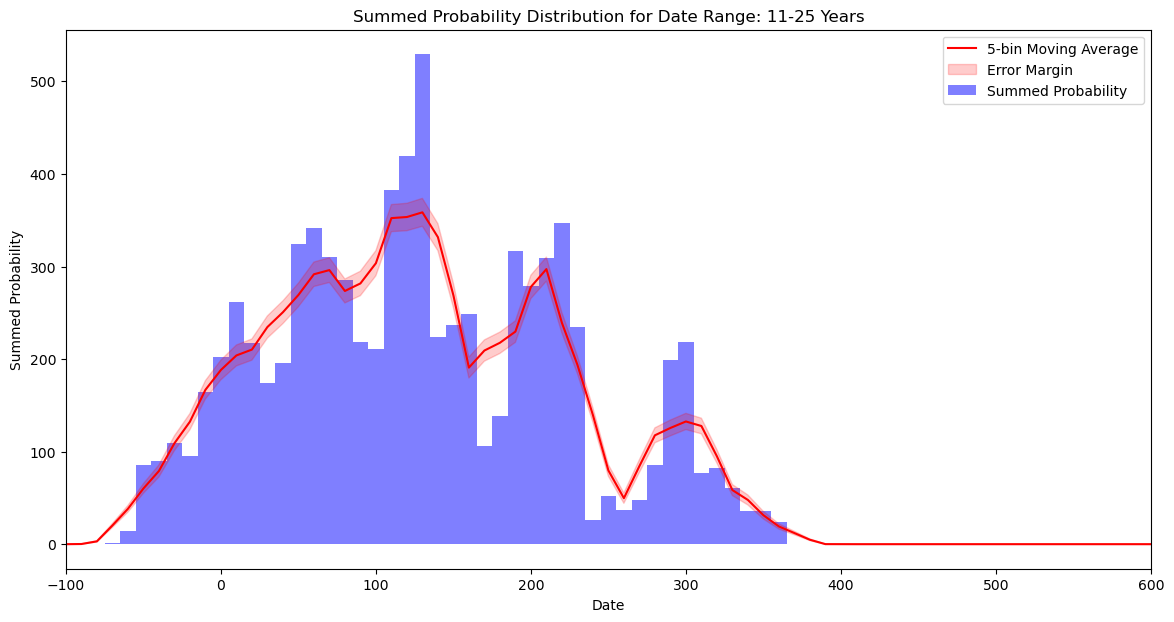

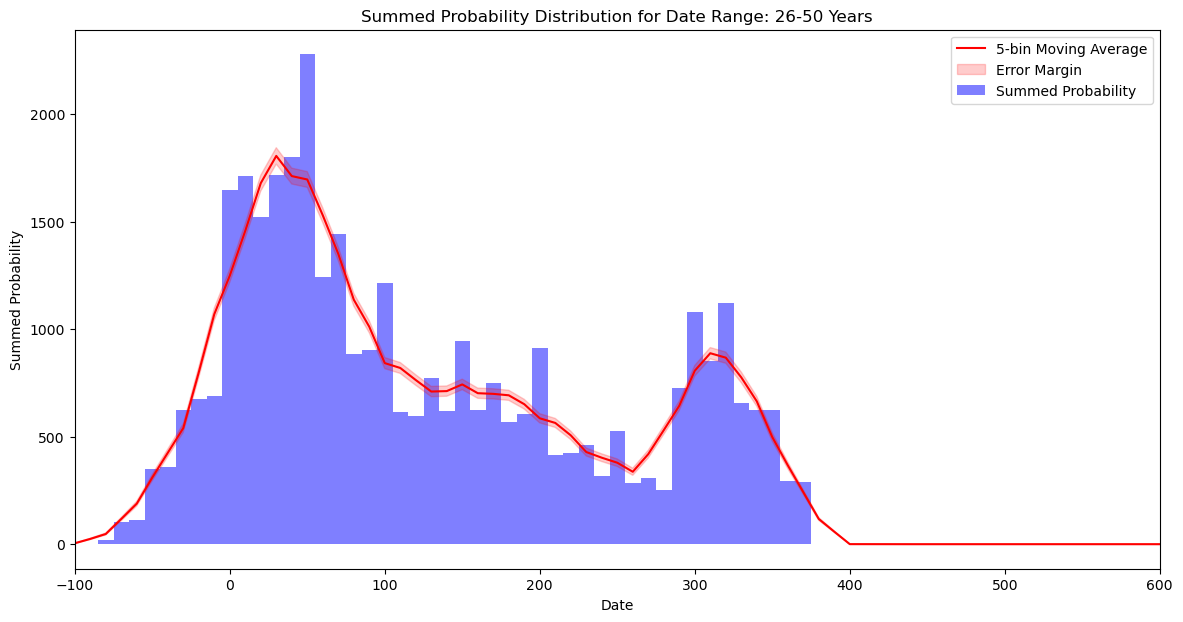

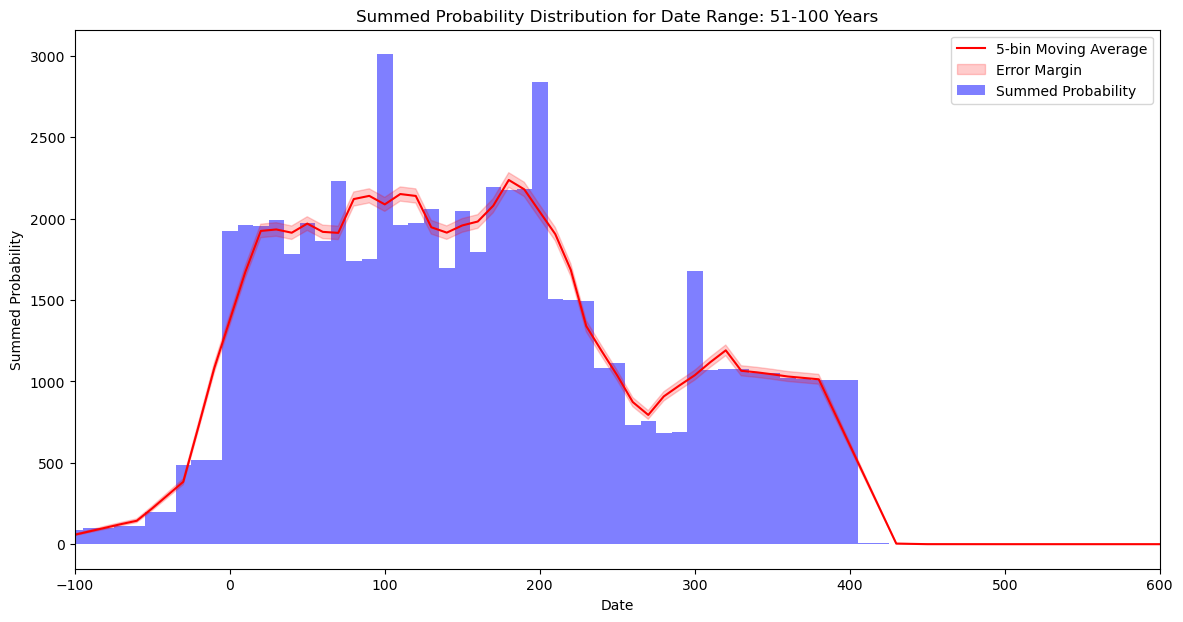

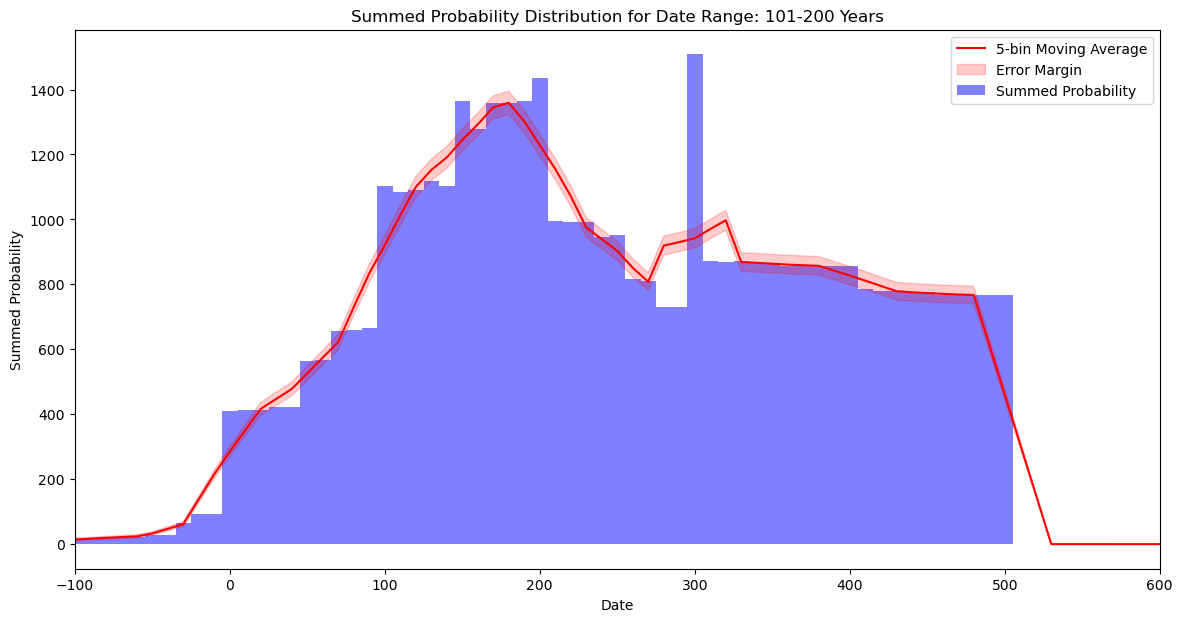

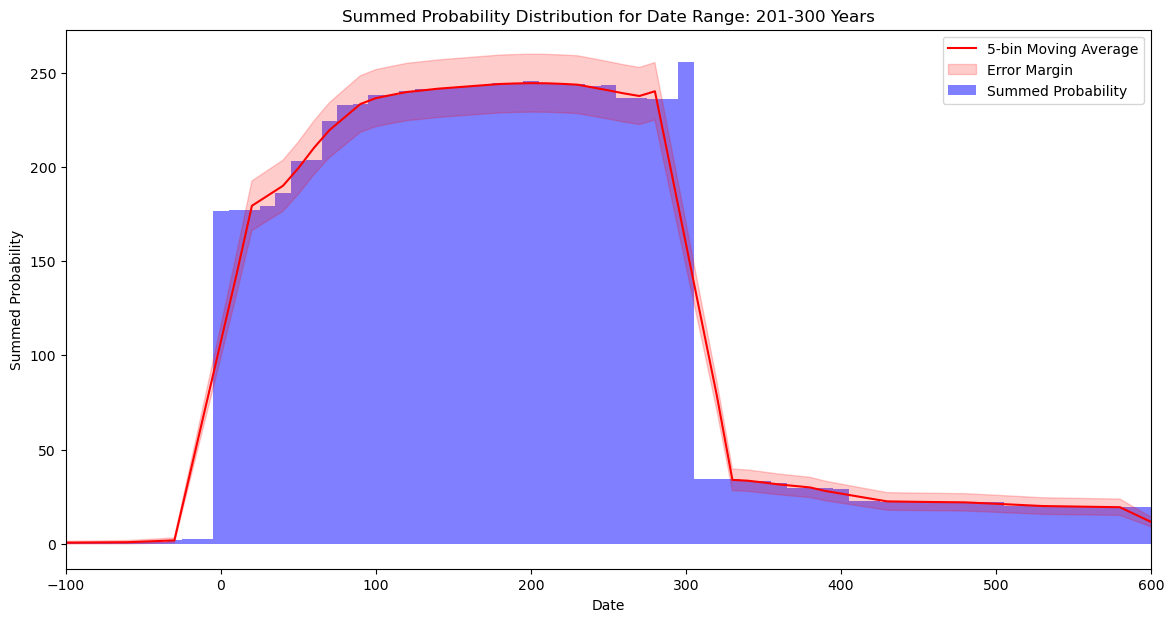

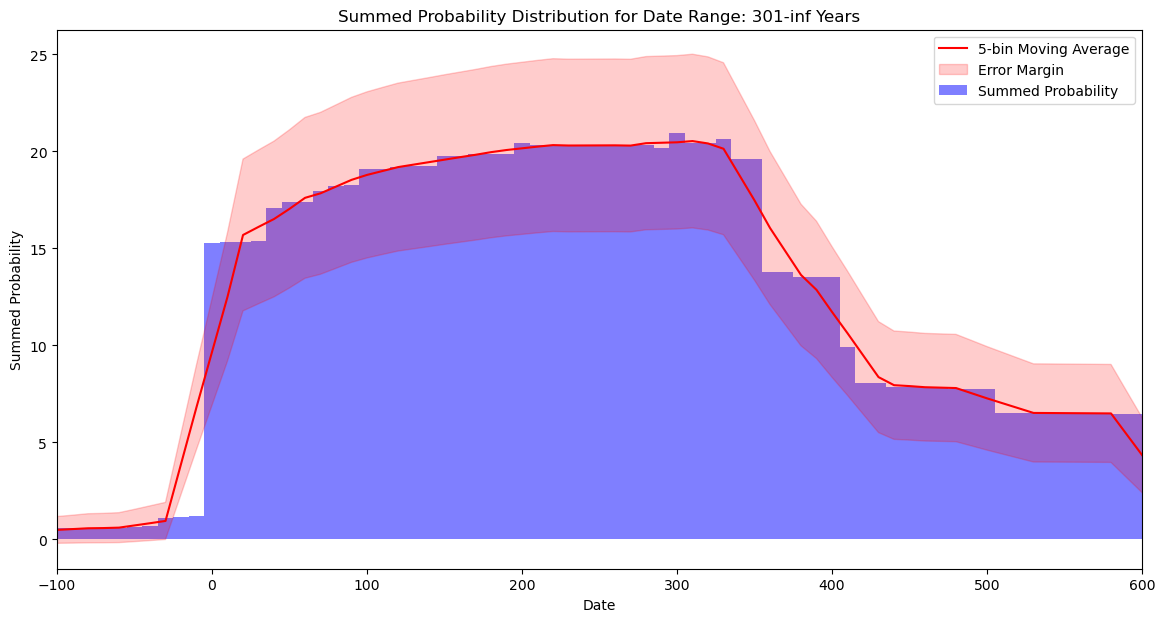

In [97]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=10):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# Define date range thresholds for filtering
thresholds = [(0, 0), (1, 10), (11, 25), (26, 50), (51, 100), (101, 200), (201, 300), (301, float('inf'))]

# Define overall earliest and latest date in the dataset, and bin resolution
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 10

# Loop through each date range and plot
for start, end in thresholds:
    if end == float('inf'):
        subset_df = lire[lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = lire[lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] <= end)]
        label = f"{start}-{end - 1}"
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=10)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
    plt.figure(figsize=(14, 7))
    
    # Plot the summed probability distribution
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    
   # Calculate and plot the moving average
    window_size = 5
    moving_avg = np.convolve(summed_prob, np.ones(window_size)/window_size, mode='valid')

    # Calculate and plot the error margins
    moving_std_dev = np.convolve(std_devs, np.ones(window_size)/window_size, mode='valid')

    # Make sure moving_avg and moving_std_dev have the same length
    if len(moving_avg) != len(moving_std_dev):
        min_len = min(len(moving_avg), len(moving_std_dev))
        moving_avg = moving_avg[:min_len]
        moving_std_dev = moving_std_dev[:min_len]

    # Generate x-values for the moving average and error margins
    moving_avg_x = x_values[int(window_size/2):-int(window_size/2)+1][:len(moving_avg)]
    
    # Plot the moving average
    plt.plot(moving_avg_x, moving_avg, color='red', label=f"{window_size}-bin Moving Average")
    plt.fill_between(moving_avg_x, moving_avg - moving_std_dev, moving_avg + moving_std_dev, color='red', alpha=0.2, label='Error Margin')  # Added label here
    plt.title(f"Summed Probability Distribution for Date Range, {resolution}-year bins: {start}-{end} Years")

    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()


#### *Under* various thresholds

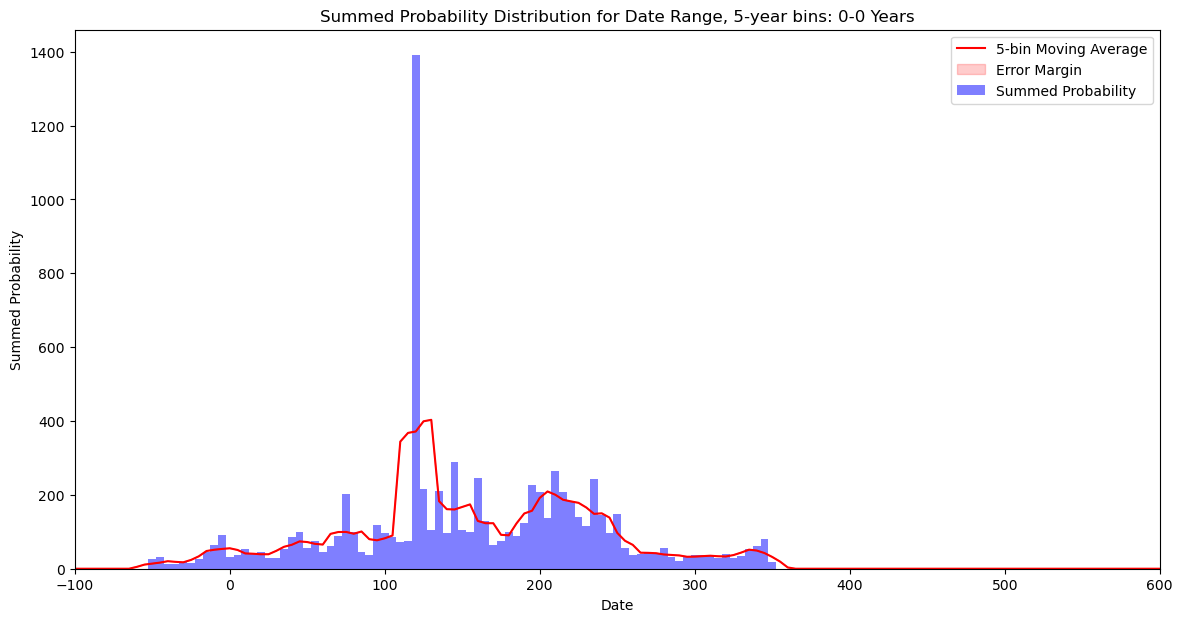

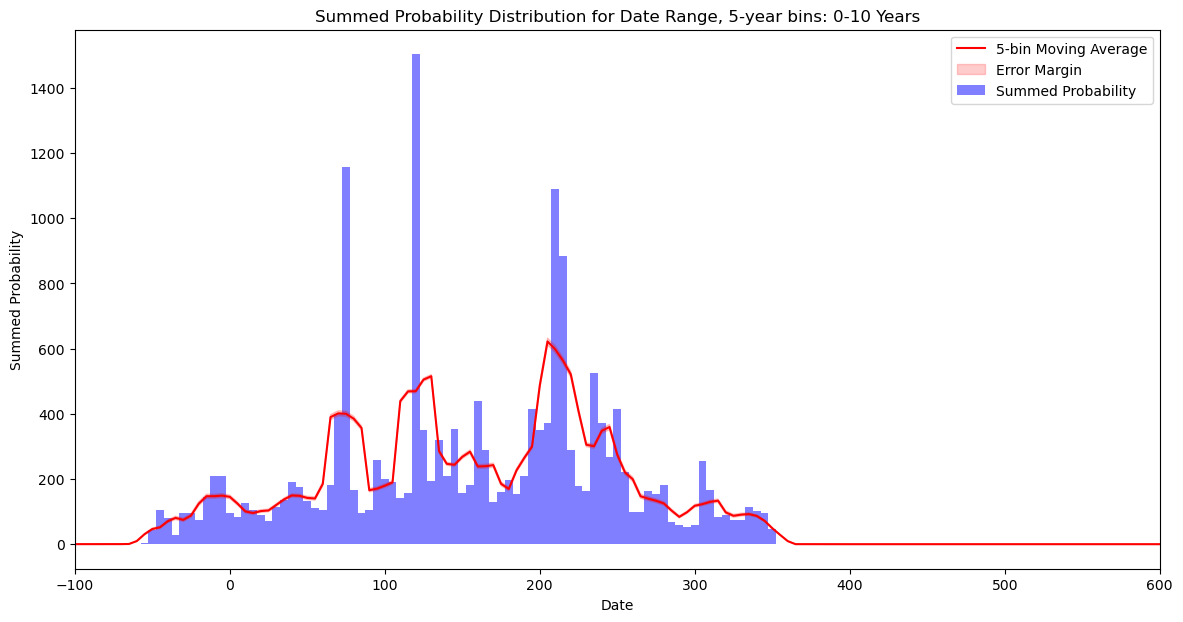

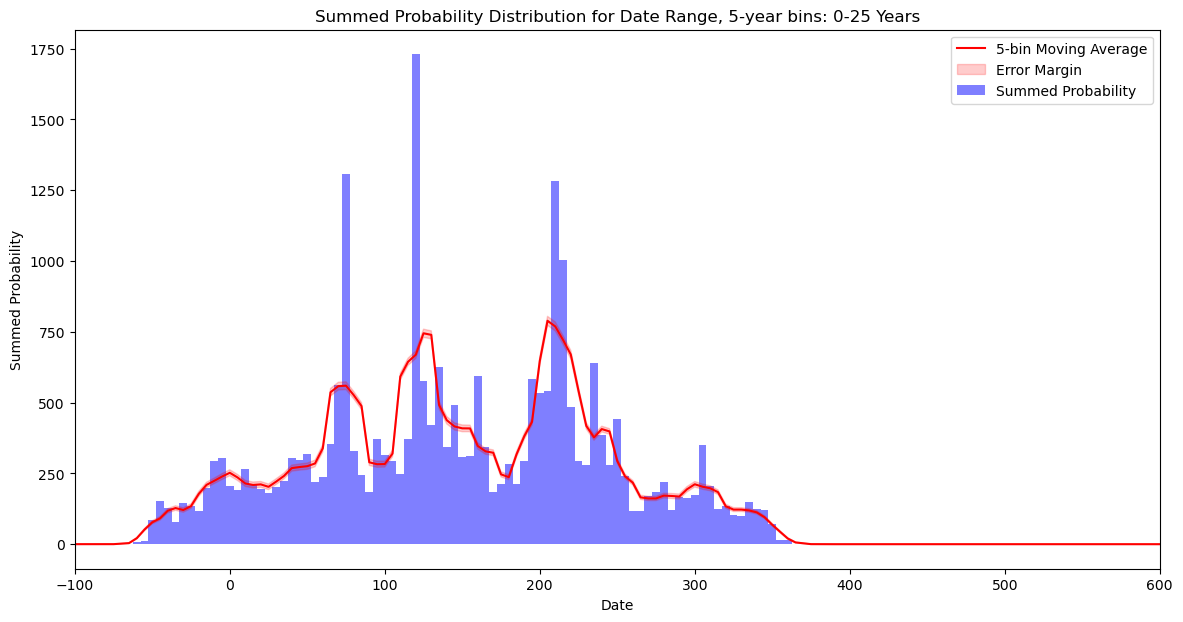

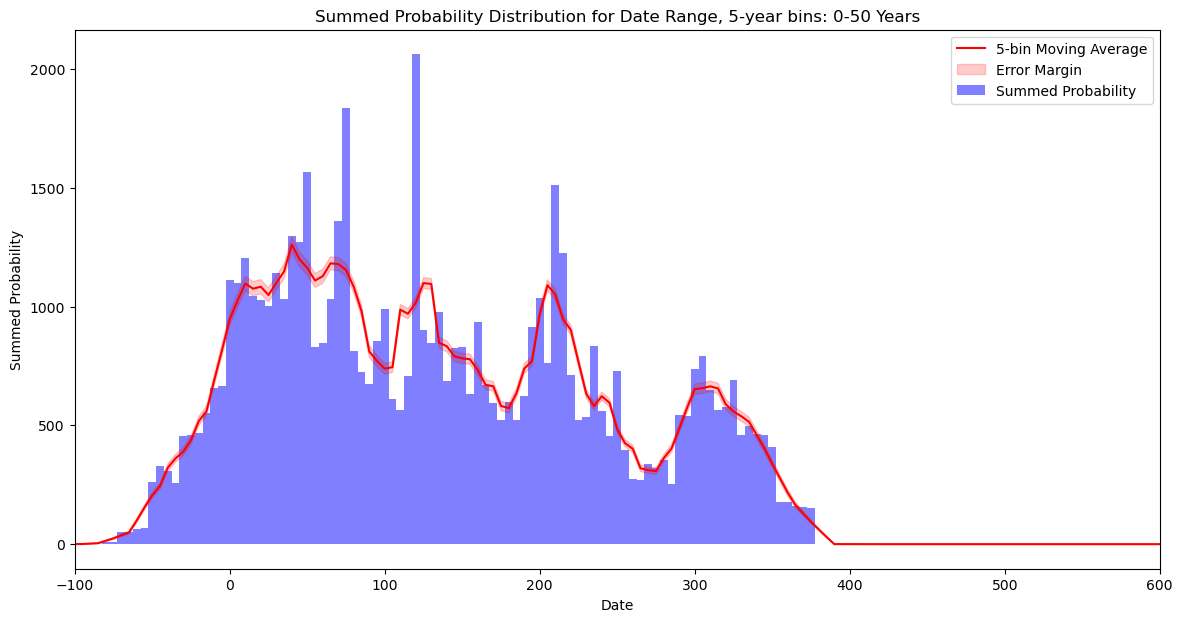

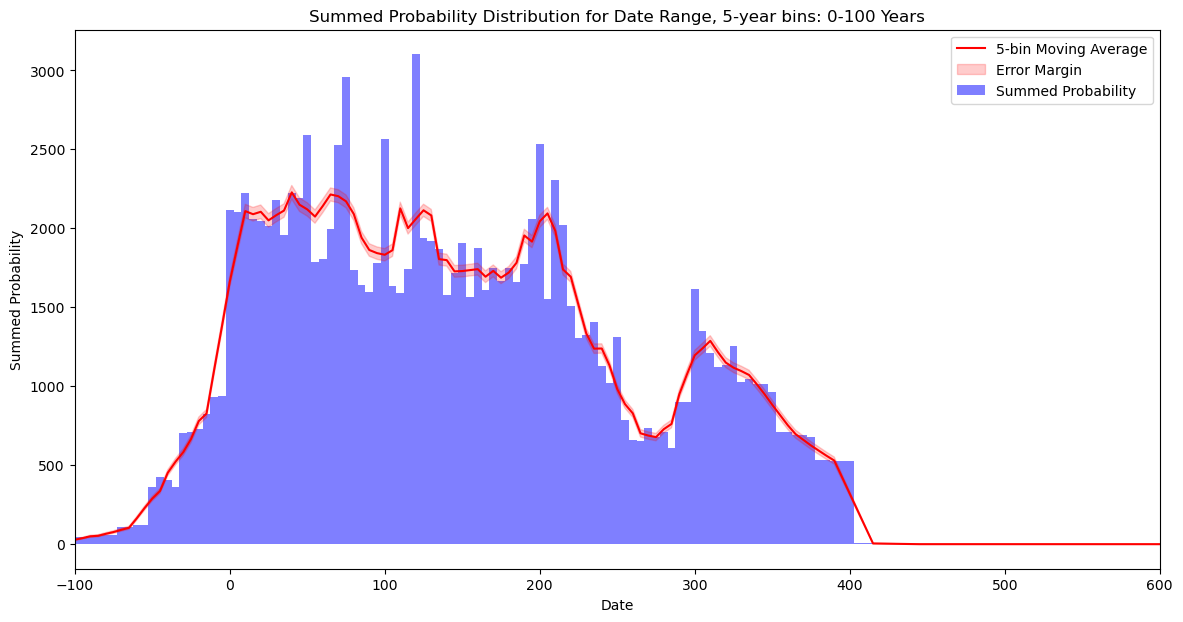

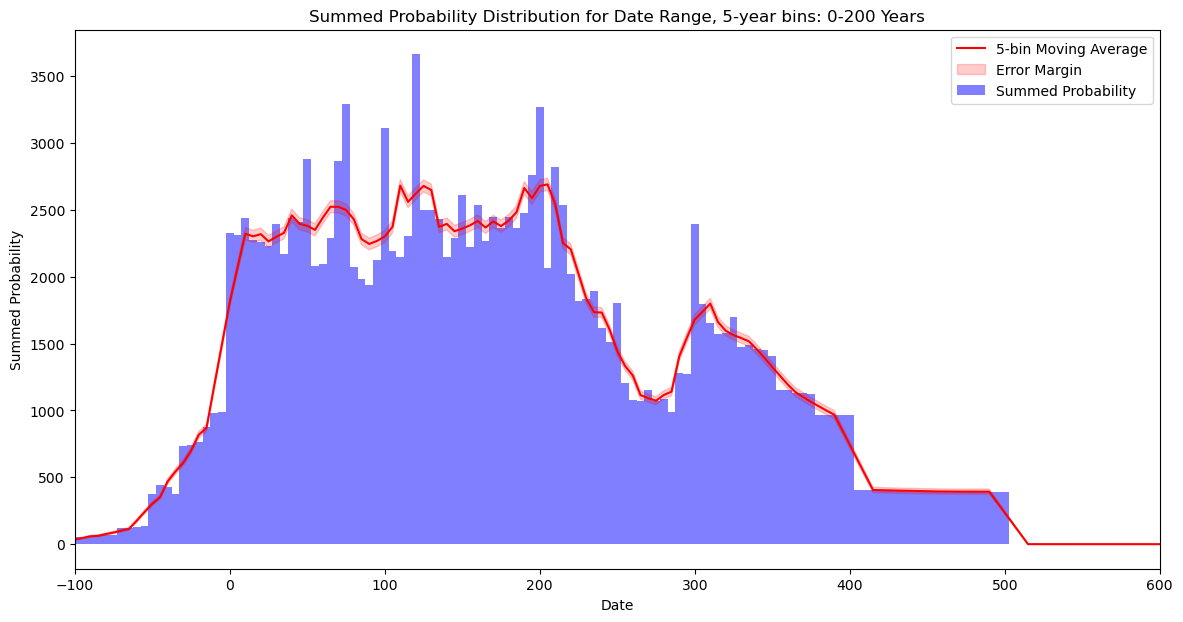

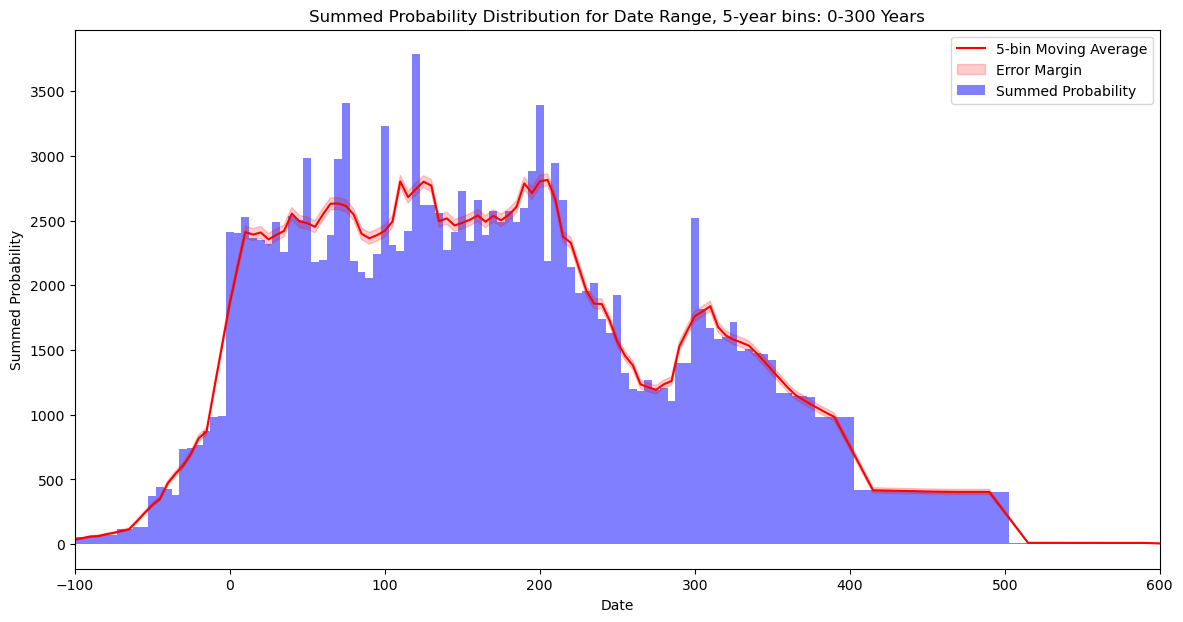

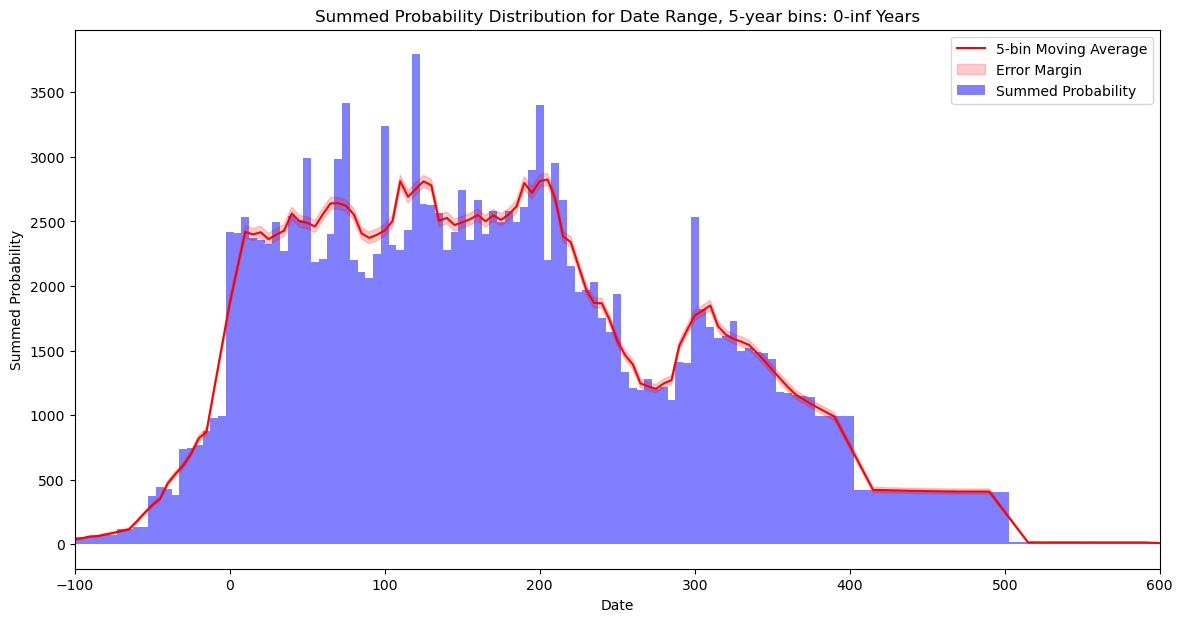

In [104]:
def compute_summed_probability(df, earliest_date, latest_date, resolution=5):
    """
    Compute the summed probability distribution of inscriptions with error margins.
    
    Parameters:
    - df: DataFrame containing the date ranges
    - earliest_date, latest_date: the date limits for the distribution
    - resolution: bin size for the histogram (in years)
    
    Returns:
    - summed_prob: summed probability distribution
    - std_devs: standard deviations for each bin
    """
    num_bins = int((latest_date - earliest_date) / resolution)
    summed_prob = np.zeros(num_bins)
    std_devs = np.zeros(num_bins)
    
    for _, row in df.iterrows():
        start_date = row['not_before']
        end_date = row['not_after']
        start_idx = int((start_date - earliest_date) / resolution)
        end_idx = int((end_date - earliest_date) / resolution)
        
        # Avoid negative or out-of-bounds indices
        start_idx = max(0, min(start_idx, num_bins - 1))
        end_idx = max(0, min(end_idx, num_bins - 1))
        
        # Calculate uniform probability for the given date range
        uniform_prob = 1.0 / (end_idx - start_idx + 1) if end_idx >= start_idx else 0
        
        # Distribute this uniform probability across the bins for the date range
        for i in range(start_idx, end_idx + 1):
            summed_prob[i] += uniform_prob
            std_devs[i] += (uniform_prob * (1 - uniform_prob))
            
    # Convert variances to standard deviations
    std_devs = np.sqrt(std_devs)
    
    return summed_prob, std_devs

# Define date range thresholds for filtering; note that calculations are now *below* rather than *between* thresholds
thresholds = [(0, 0), (0, 10), (0, 25), (0, 50), (0, 100), (0, 200), (0, 300), (0, float('inf'))]

# Define overall earliest and latest date in the dataset, and bin resolution
earliest_date, latest_date = lire['not_before'].min(), lire['not_after'].max()
resolution = 5

# Loop through each date range and plot
for start, end in thresholds:
    if end == float('inf'):
        subset_df = lire[lire['date_range'] >= start]
        label = f"{start}+"
    elif start == 0 and end == 0:
        subset_df = lire[lire['date_range'] == 0]
        label = f"{start}"
    else:
        subset_df = lire[(lire['date_range'] >= start) & (lire['date_range'] <= end)]
        label = f"{start}-{end - 1}"
    
    # Calculate the summed probability and standard deviations for the filtered data
    summed_prob, std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution=5)
    
    # Generate x-values for plotting, making sure they align in shape with summed_prob
    x_values = np.arange(earliest_date, latest_date, resolution)[:len(summed_prob)]
    
    plt.figure(figsize=(14, 7))
    
    # Plot the summed probability distribution
    plt.bar(x_values, summed_prob, width=resolution, color='blue', alpha=0.5, label='Summed Probability')
    
   # Calculate and plot the moving average
    window_size = 5
    moving_avg = np.convolve(summed_prob, np.ones(window_size)/window_size, mode='valid')

    # Calculate and plot the error margins
    moving_std_dev = np.convolve(std_devs, np.ones(window_size)/window_size, mode='valid')

    # Make sure moving_avg and moving_std_dev have the same length
    if len(moving_avg) != len(moving_std_dev):
        min_len = min(len(moving_avg), len(moving_std_dev))
        moving_avg = moving_avg[:min_len]
        moving_std_dev = moving_std_dev[:min_len]

    # Generate x-values for the moving average and error margins
    moving_avg_x = x_values[int(window_size/2):-int(window_size/2)+1][:len(moving_avg)]
    
    # Plot the moving average
    plt.plot(moving_avg_x, moving_avg, color='red', label=f"{window_size}-bin Moving Average")
    plt.fill_between(moving_avg_x, moving_avg - moving_std_dev, moving_avg + moving_std_dev, color='red', alpha=0.2, label='Error Margin')  # Added label here
    plt.title(f"Summed Probability Distribution for Date Range, {resolution}-year bins: {start}-{end} Years")

    plt.xlabel('Date')
    plt.xlim([-100, 600])
    plt.ylabel('Summed Probability')
    plt.legend()
    
    plt.show()


# Determine minimum necessary sample size needed

## Monte carlo simulation, 500-sample test run

In [101]:
from sklearn.metrics import mean_squared_error
import random

# Function to compute RMSE between two probability distributions
def compute_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Step 1: Compute summed probability and standard deviations for the full dataset
full_summed_prob, full_std_devs = compute_summed_probability(lire, earliest_date, latest_date, resolution)

# Initialize variables to store RMSE and error margins for each iteration
rmse_values = []

# Monte Carlo simulation with 1000 iterations
num_iterations = 1000
sample_size = 500

for i in range(num_iterations):
    # Step 2: Randomly select 500 dates from the full dataset
    subset_df = lire.sample(n=sample_size, random_state=i)
    
    # Compute summed probability and standard deviations for the subset
    subset_summed_prob, subset_std_devs = compute_summed_probability(subset_df, earliest_date, latest_date, resolution)
    
    # Match the lengths before calculating RMSE (this could happen if the randomly selected data does not cover the entire date range)
    min_len = min(len(full_summed_prob), len(subset_summed_prob))
    full_summed_prob_trunc = full_summed_prob[:min_len]
    subset_summed_prob_trunc = subset_summed_prob[:min_len]
    
    # Step 3: Compute RMSE and store it
    rmse = compute_rmse(full_summed_prob_trunc, subset_summed_prob_trunc)
    rmse_values.append(rmse)

# Calculate mean RMSE and its standard deviation as error margin
mean_rmse = np.mean(rmse_values)
std_dev_rmse = np.std(rmse_values)

print(f"Mean RMSE: {mean_rmse}, RMSE Error Margin: {std_dev_rmse}")


Mean RMSE: 1696.151681687125, RMSE Error Margin: 0.06054599091653245


## Simulation including samples from 100-10000 records

Sample Size: 10, Mean RMSE: 1700.7124374056864, RMSE Error Margin: 0.009194419520295004
Sample Size: 25, Mean RMSE: 1700.5728171320798, RMSE Error Margin: 0.01389066391260166
Sample Size: 50, Mean RMSE: 1700.3400310139632, RMSE Error Margin: 0.019313232618478796
Sample Size: 100, Mean RMSE: 1699.875198687311, RMSE Error Margin: 0.029132982709228962
Sample Size: 250, Mean RMSE: 1698.4801313074254, RMSE Error Margin: 0.041984129667366324


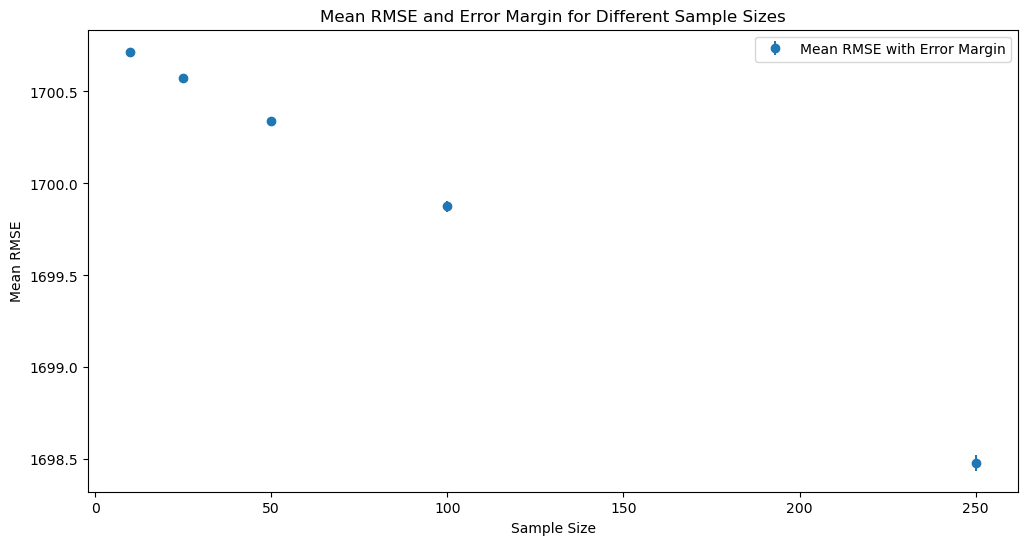

In [103]:
from sklearn.metrics import mean_squared_error

# Assuming lire is your DataFrame and compute_summed_probability is defined as before
# Also, earliest_date, latest_date, and resolution are defined as in your previous code

def monte_carlo_simulation(full_dataset, sample_size, num_iterations=1000):
    """
    Perform Monte Carlo simulation to calculate Mean RMSE and RMSE Error Margin.
    
    Parameters:
    - full_dataset: DataFrame containing the full dataset
    - sample_size: size of the random samples to be drawn from the full dataset
    - num_iterations: number of iterations for the Monte Carlo simulation
    
    Returns:
    - mean_rmse: Mean RMSE across all iterations
    - rmse_error_margin: RMSE Error Margin across all iterations
    """
    # Initialize variables to store RMSE and error margins for each iteration
    rmse_values = []

    full_summed_prob, _ = compute_summed_probability(full_dataset, earliest_date, latest_date, resolution=resolution)
    
    for _ in range(num_iterations):
        # Randomly sample data
        sample_df = full_dataset.sample(n=sample_size)
        
        # Compute summed probability for the sample
        sample_summed_prob, _ = compute_summed_probability(sample_df, earliest_date, latest_date, resolution=resolution)
        
        # Compute RMSE between the full dataset and the sample
        rmse = np.sqrt(mean_squared_error(full_summed_prob, sample_summed_prob))
        
        rmse_values.append(rmse)

    mean_rmse = np.mean(rmse_values)
    rmse_error_margin = np.std(rmse_values)

    return mean_rmse, rmse_error_margin

# Define sample sizes to investigate
sample_sizes = [10, 25, 50, 100, 250]

# Initialize lists to store Mean RMSE and RMSE Error Margin for each sample size
mean_rmses = []
rmse_error_margins = []

# Perform Monte Carlo simulation for each sample size
for sample_size in sample_sizes:
    mean_rmse, rmse_error_margin = monte_carlo_simulation(lire, sample_size)
    
    print(f"Sample Size: {sample_size}, Mean RMSE: {mean_rmse}, RMSE Error Margin: {rmse_error_margin}")
    
    mean_rmses.append(mean_rmse)
    rmse_error_margins.append(rmse_error_margin)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.errorbar(sample_sizes, mean_rmses, yerr=rmse_error_margins, fmt='o', label='Mean RMSE with Error Margin')
plt.xlabel('Sample Size')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE and Error Margin for Different Sample Sizes')
plt.legend()
plt.show()


This isn't working. Going to start from scratch using the approach in Williams 2019, 580-581. Step one is determining 'delta-T'the mean of the standard deviations reported for dates in the sample.

## Calculate $\Delta$T

Mean of date-range standard deviations for various data slices

In [105]:
# Calculate the date-range standard deviations for each record
lire['date_range_std_dev'] = (lire['not_after'] - lire['not_before']) / np.sqrt(12)  # Assuming uniform distribution

# Calculate the mean of these standard deviations
mean_std_dev = lire['date_range_std_dev'].mean()

print(f"The mean of the date-range standard deviations is: {mean_std_dev}")

The mean of the date-range standard deviations is: 29.239053317812306


What if I eliminate all records where date_range > 300?

In [109]:
# Filter out records with a date range greater than 200
filtered_lire = lire.query('date_range <= 200')

# Alternatively, using boolean indexing
# filtered_lire = lire[lire['date_range'] <= 200]

# Calculate the date-range standard deviations for each record in the filtered DataFrame
filtered_lire['date_range_std_dev'] = (filtered_lire['not_after'] - filtered_lire['not_before']) / np.sqrt(12)

# Calculate the mean of these standard deviations in the filtered DataFrame
mean_std_dev_filtered = filtered_lire['date_range_std_dev'].mean()

# Count the number of records in the filtered DataFrame
num_records_filtered = len(filtered_lire)

print(f"The mean of the date-range standard deviations (after filtering) is: {mean_std_dev_filtered}")
print(f"The number of records in the filtered dataset is: {num_records_filtered} of {total_records} total records")

The mean of the date-range standard deviations (after filtering) is: 26.304157933139265
The number of records in the filtered dataset is: 173925 of 182852 total records


/home/shawn/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Works, now calculating for records under various thresholds

In [111]:
# Define date range thresholds for filtering; calculations are now *below* rather than *between* thresholds
thresholds = [50, 100, 200, 300, float('inf')]

for threshold in thresholds:
    # Filter the data for records with a date range below the current threshold
    filtered_lire = lire[lire['date_range'] <= threshold]
    
    # Calculate the date-range standard deviations for each record in the filtered DataFrame
    filtered_lire['date_range_std_dev'] = (filtered_lire['not_after'] - filtered_lire['not_before']) / np.sqrt(12)
    
    # Calculate the mean of these standard deviations in the filtered DataFrame
    mean_std_dev_filtered = filtered_lire['date_range_std_dev'].mean()
    
    # Count the number of records in the filtered DataFrame
    num_records_filtered = len(filtered_lire)
    
    print(f"For date range cut-off below {threshold} years:")
    print(f"The mean of the date-range standard deviations is: {mean_std_dev_filtered}")
    print(f"The number of records in the filtered dataset is: {num_records_filtered}")
    print('-'*50)


For date range cut-off below 50 years:
The mean of the date-range standard deviations is: 7.988212265149121
The number of records in the filtered dataset is: 61743
--------------------------------------------------
For date range cut-off below 100 years:
The mean of the date-range standard deviations is: 17.49287222466126
The number of records in the filtered dataset is: 128936
--------------------------------------------------
For date range cut-off below 200 years:
The mean of the date-range standard deviations is: 26.33484949652472
The number of records in the filtered dataset is: 174095
--------------------------------------------------
For date range cut-off below 300 years:
The mean of the date-range standard deviations is: 28.73718320151814
The number of records in the filtered dataset is: 181925
--------------------------------------------------
For date range cut-off below inf years:
The mean of the date-range standard deviations is: 29.239053317812306
The number of records in

Ok, attempting to apply the approach suggested by Williams 2012, which if I understand correctly works like this:

1. Create a summed probability analysis for the full dataset using 5-year bins, similar to what we have done previously.
2. Take a random sample (let's start with 500 records).
3. Create a summed probability analysis on that sample, using the same 5-year bins.
4. Calculate mean square error (MSE) between the two summed probability analyses for each bin that occurs in both.
5. Sum the MSE for all bins.
6. Repeat steps 2-5 50 times.
7. Sum the outputs from all iterations.

No, didn't work, going to try it step-by-step instead

### Estimate minimum necessary sample size

1. Create a summed probability analysis for the full dataset using 5-year bins.
2. Take a random sample of 50 records from the full dataset.
3. Create a summed probability analysis for the sample using the same 5-year bins.
4. For each bin, show me the summed probability from the full dataset, the summed probability from the sample, and the variance between them.

None of my attempts to calculate MSE according to Willaims 2012 worked. Starting over using the approach described at https://ealizadeh.com/blog/statistics-data-vs-sampling-distribution/. I think I will start by comparing the mean of date ranges in the sample to the mean of date ranges in the population, then try it comparing SP.

#### Standard Error (SE) of the date-range mean via bootstrapping

In [121]:
import numpy as np
import pandas as pd

# Number of bootstrap iterations
n_iterations = 1000

# Sample size
sample_size = 500

# Calculate the mean date range for the entire dataset
mean_date_range_full = lire['date_range'].mean()

# Initialize an empty list to hold the bootstrap sample means
bootstrap_sample_means = []

# Bootstrap sampling
for i in range(n_iterations):
    # Sample with replacement from the dataset
    bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)
    
    # Calculate the mean of the bootstrap sample
    bootstrap_sample_mean = bootstrap_sample.mean()
    
    # Store the mean in the list
    bootstrap_sample_means.append(bootstrap_sample_mean)

# Convert to a NumPy array for easier calculations
bootstrap_sample_means = np.array(bootstrap_sample_means)

# Calculate the standard error
standard_error = np.std(bootstrap_sample_means)

print(f"Mean date range for full dataset: {mean_date_range_full}")
print(f"Standard Error of the mean date range for sample size of {sample_size}: {standard_error}")


Mean date range for full dataset: 101.28705182333253
Standard Error of the mean date range for sample size of 500: 3.657134812322893


Add some more information: standard deviation of the full dataset, mean of the sample, SD of the sample

In [122]:
import numpy as np
import pandas as pd

# Assuming lire is your DataFrame
# lire = pd.read_csv("your_dataset.csv")

# Number of bootstrap iterations
n_iterations = 1000

# Sample size
sample_size = 500

# Calculate the mean and standard deviation of the date range for the entire dataset
mean_date_range_full = lire['date_range'].mean()
std_date_range_full = lire['date_range'].std()

# Initialize empty lists to hold the bootstrap sample means and standard deviations
bootstrap_sample_means = []
bootstrap_sample_stds = []

# Bootstrap sampling
for i in range(n_iterations):
    # Sample with replacement from the dataset
    bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)
    
    # Calculate the mean and standard deviation of the bootstrap sample
    bootstrap_sample_mean = bootstrap_sample.mean()
    bootstrap_sample_std = bootstrap_sample.std()
    
    # Store the mean and standard deviation in the lists
    bootstrap_sample_means.append(bootstrap_sample_mean)
    bootstrap_sample_stds.append(bootstrap_sample_std)

# Convert to NumPy arrays for easier calculations
bootstrap_sample_means = np.array(bootstrap_sample_means)
bootstrap_sample_stds = np.array(bootstrap_sample_stds)

# Calculate the standard error for the sample mean
standard_error = np.std(bootstrap_sample_means)

# Calculate the mean and standard deviation for the bootstrap samples
mean_bootstrap_samples = np.mean(bootstrap_sample_means)
std_bootstrap_samples = np.mean(bootstrap_sample_stds)

print(f"Mean date range for full dataset: {mean_date_range_full}")
print(f"Standard Deviation of date range for full dataset: {std_date_range_full}")
print(f"Mean date range for bootstrap samples: {mean_bootstrap_samples}")
print(f"Standard Deviation of date range for bootstrap samples: {std_bootstrap_samples}")
print(f"Standard Error of the mean date range for sample size of {sample_size}: {standard_error}")


Mean date range for full dataset: 101.28705182333253
Standard Deviation of date range for full dataset: 76.75115026800985
Mean date range for bootstrap samples: 101.251656
Standard Deviation of date range for bootstrap samples: 76.73230296237229
Standard Error of the mean date range for sample size of 500: 3.4753478470023684


In [125]:
import numpy as np
import pandas as pd

# Assuming lire is your DataFrame
# lire = pd.read_csv("your_dataset.csv")

# Number of bootstrap iterations
n_iterations = 1000

# Sample sizes to investigate
sample_sizes = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 25000]

# Calculate the mean and standard deviation of the date range for the entire dataset
mean_date_range_full = lire['date_range'].mean()
std_date_range_full = lire['date_range'].std()

# Initialize a dictionary to hold results for each sample size
results = {}

# Loop through each sample size
for sample_size in sample_sizes:
    
    # Initialize empty lists to hold the bootstrap sample means and standard deviations
    bootstrap_sample_means = []
    bootstrap_sample_stds = []

    # Bootstrap sampling
    for i in range(n_iterations):
        # Sample with replacement from the dataset
        bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)

        # Calculate the mean and standard deviation of the bootstrap sample
        bootstrap_sample_mean = bootstrap_sample.mean()
        bootstrap_sample_std = bootstrap_sample.std()

        # Store the mean and standard deviation in the lists
        bootstrap_sample_means.append(bootstrap_sample_mean)
        bootstrap_sample_stds.append(bootstrap_sample_std)

    # Convert to NumPy arrays for easier calculations
    bootstrap_sample_means = np.array(bootstrap_sample_means)
    bootstrap_sample_stds = np.array(bootstrap_sample_stds)

    # Calculate the standard error for the sample mean
    standard_error = np.std(bootstrap_sample_means)

    # Calculate the mean and standard deviation for the bootstrap samples
    mean_bootstrap_samples = np.mean(bootstrap_sample_means)
    std_bootstrap_samples = np.mean(bootstrap_sample_stds)

    # Store results in the dictionary
    results[sample_size] = {
        'mean_bootstrap_samples': mean_bootstrap_samples,
        'std_bootstrap_samples': std_bootstrap_samples,
        'standard_error': standard_error
    }

print(f"Mean date range for full dataset: {mean_date_range_full}")
print(f"Standard Deviation of date range for full dataset: {std_date_range_full}")

# Display the results
for sample_size, metrics in results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean date range for bootstrap samples: {metrics['mean_bootstrap_samples']}")
    print(f"  Standard Deviation of date range for bootstrap samples: {metrics['std_bootstrap_samples']}")
    print(f"  Standard Error of the mean date range: {metrics['standard_error']}")


Mean date range for full dataset: 101.28705182333253
Standard Deviation of date range for full dataset: 76.75115026800985

For a sample size of 10:
  Mean date range for bootstrap samples: 101.8767
  Standard Deviation of date range for bootstrap samples: 74.04174589953857
  Standard Error of the mean date range: 24.421835047964763

For a sample size of 25:
  Mean date range for bootstrap samples: 100.83775999999999
  Standard Deviation of date range for bootstrap samples: 75.19898785629543
  Standard Error of the mean date range: 14.61424252509859

For a sample size of 50:
  Mean date range for bootstrap samples: 100.52212
  Standard Deviation of date range for bootstrap samples: 75.1634463448233
  Standard Error of the mean date range: 10.466887957057724

For a sample size of 100:
  Mean date range for bootstrap samples: 101.23407
  Standard Deviation of date range for bootstrap samples: 76.15310325873145
  Standard Error of the mean date range: 7.656186122025771

For a sample size o

Now with a plot

Mean date range for full dataset: 101.28705182333253
Standard Deviation of date range for full dataset: 76.75115026800985

For a sample size of 10:
  Mean date range for bootstrap samples: 102.817
  Standard Deviation of date range for bootstrap samples: 74.35154875496448
  Standard Error of the mean date range: 25.49471653107757

For a sample size of 25:
  Mean date range for bootstrap samples: 100.96024
  Standard Deviation of date range for bootstrap samples: 74.79414033608346
  Standard Error of the mean date range: 14.648627619760154

For a sample size of 50:
  Mean date range for bootstrap samples: 101.05032
  Standard Deviation of date range for bootstrap samples: 75.73468980218863
  Standard Error of the mean date range: 11.207964128136743

For a sample size of 100:
  Mean date range for bootstrap samples: 101.18621
  Standard Deviation of date range for bootstrap samples: 76.17742494165738
  Standard Error of the mean date range: 7.646626127639562

For a sample size of 250:
  

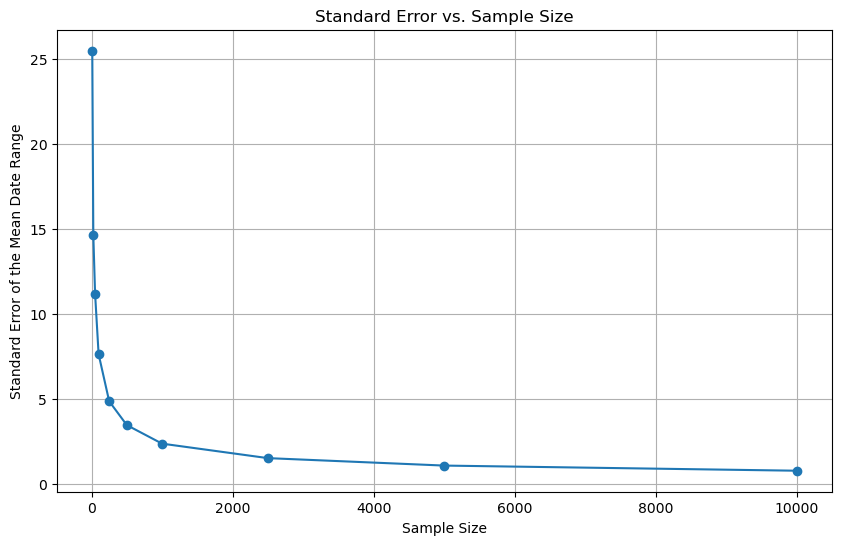

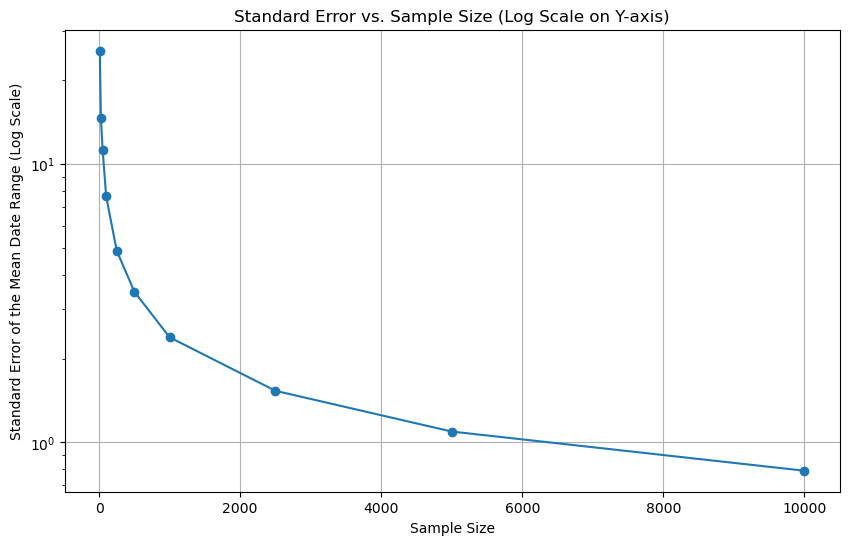

In [128]:
# Assuming lire is your DataFrame
# lire = pd.read_csv("your_dataset.csv")

# Number of bootstrap iterations
n_iterations = 1000

# Sample sizes to investigate
sample_sizes = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000]

# Calculate the mean and standard deviation of the date range for the entire dataset
mean_date_range_full = lire['date_range'].mean()
std_date_range_full = lire['date_range'].std()

# Initialize a dictionary to hold results for each sample size
results = {}

# Initialize empty list to store standard error values for plotting
standard_errors = []

# Loop through each sample size
for sample_size in sample_sizes:
    
    # Initialize empty lists to hold the bootstrap sample means and standard deviations
    bootstrap_sample_means = []
    bootstrap_sample_stds = []

    # Bootstrap sampling
    for i in range(n_iterations):
        # Sample with replacement from the dataset
        bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)

        # Calculate the mean and standard deviation of the bootstrap sample
        bootstrap_sample_mean = bootstrap_sample.mean()
        bootstrap_sample_std = bootstrap_sample.std()

        # Store the mean and standard deviation in the lists
        bootstrap_sample_means.append(bootstrap_sample_mean)
        bootstrap_sample_stds.append(bootstrap_sample_std)

    # Convert to NumPy arrays for easier calculations
    bootstrap_sample_means = np.array(bootstrap_sample_means)
    bootstrap_sample_stds = np.array(bootstrap_sample_stds)

    # Calculate the standard error for the sample mean
    standard_error = np.std(bootstrap_sample_means)

    # Store the standard error for plotting
    standard_errors.append(standard_error)

    # Calculate the mean and standard deviation for the bootstrap samples
    mean_bootstrap_samples = np.mean(bootstrap_sample_means)
    std_bootstrap_samples = np.mean(bootstrap_sample_stds)

    # Store results in the dictionary
    results[sample_size] = {
        'mean_bootstrap_samples': mean_bootstrap_samples,
        'std_bootstrap_samples': std_bootstrap_samples,
        'standard_error': standard_error
    }

print(f"Mean date range for full dataset: {mean_date_range_full}")
print(f"Standard Deviation of date range for full dataset: {std_date_range_full}")

# Display the results
for sample_size, metrics in results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean date range for bootstrap samples: {metrics['mean_bootstrap_samples']}")
    print(f"  Standard Deviation of date range for bootstrap samples: {metrics['std_bootstrap_samples']}")
    print(f"  Standard Error of the mean date range: {metrics['standard_error']}")

# Plotting the standard errors
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Standard Error of the Mean Date Range')
plt.title('Standard Error vs. Sample Size')
plt.grid(True)
plt.show()

# Plotting with a log scale on the y-axis
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors, marker='o')
plt.yscale('log')
plt.xlabel('Sample Size')
plt.ylabel('Standard Error of the Mean Date Range (Log Scale)')
plt.title('Standard Error vs. Sample Size (Log Scale on Y-axis)')
plt.grid(True)
plt.show()


Now focusing in on the knee of the curve

Mean date range for full dataset: 101.28705182333253
Standard Deviation of date range for full dataset: 76.75115026800985

For a sample size of 25:
  Mean date range for bootstrap samples: 101.43136
  Standard Deviation of date range for bootstrap samples: 75.33053938707893
  Standard Error of the mean date range: 15.456173981629476

For a sample size of 50:
  Mean date range for bootstrap samples: 101.13308
  Standard Deviation of date range for bootstrap samples: 75.5751842948077
  Standard Error of the mean date range: 10.761229637620415

For a sample size of 100:
  Mean date range for bootstrap samples: 101.17247
  Standard Deviation of date range for bootstrap samples: 76.55553249387111
  Standard Error of the mean date range: 7.578917574370367

For a sample size of 250:
  Mean date range for bootstrap samples: 101.258532
  Standard Deviation of date range for bootstrap samples: 76.33730265663239
  Standard Error of the mean date range: 4.834396538656713

For a sample size of 500:

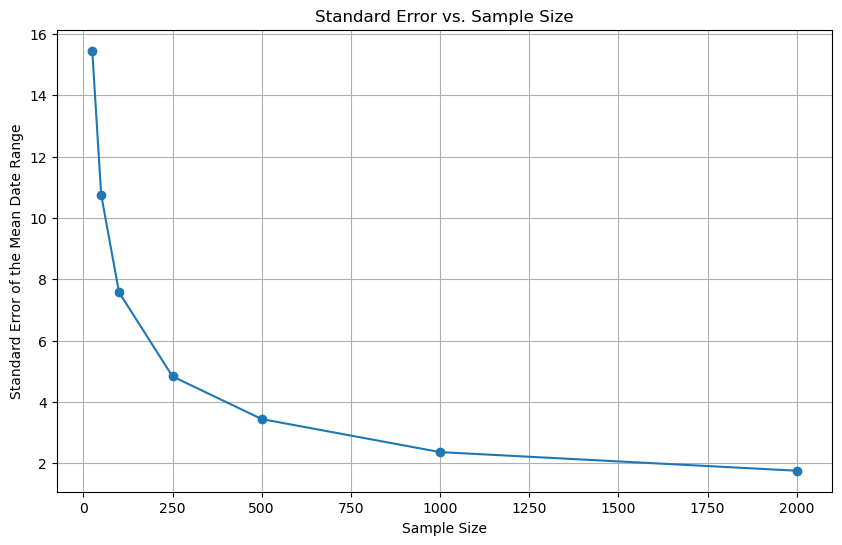

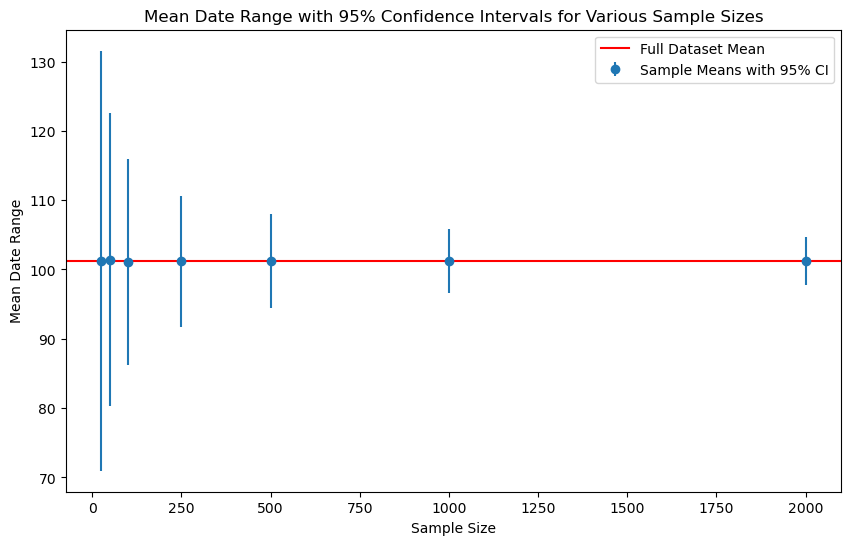

In [134]:
# Assuming lire is your DataFrame
# lire = pd.read_csv("your_dataset.csv")

# Number of bootstrap iterations
n_iterations = 1000

# Sample sizes to investigate
sample_sizes = [25, 50, 100, 250, 500, 1000, 2000]

# Calculate the mean and standard deviation of the date range for the entire dataset
mean_date_range_full = lire['date_range'].mean()
std_date_range_full = lire['date_range'].std()

# Initialize a dictionary to hold results for each sample size
results = {}

# Initialize empty list to store standard error values for plotting
standard_errors = []

# New list to store the means for each sample size
sample_means = []

# Loop through each sample size
for sample_size in sample_sizes:
    
    # Initialize empty lists to hold the bootstrap sample means and standard deviations
    bootstrap_sample_means = []
    bootstrap_sample_stds = []

    # Bootstrap sampling
    for i in range(n_iterations):
        # Sample with replacement from the dataset
        bootstrap_sample = lire['date_range'].sample(n=sample_size, replace=True)

        # Calculate the mean and standard deviation of the bootstrap sample
        bootstrap_sample_mean = bootstrap_sample.mean()
        bootstrap_sample_std = bootstrap_sample.std()

        # Store the mean and standard deviation in the lists
        bootstrap_sample_means.append(bootstrap_sample_mean)
        bootstrap_sample_stds.append(bootstrap_sample_std)

    # Convert to NumPy arrays for easier calculations
    bootstrap_sample_means = np.array(bootstrap_sample_means)
    bootstrap_sample_stds = np.array(bootstrap_sample_stds)

    # Calculate the standard error for the sample mean
    standard_error = np.std(bootstrap_sample_means)

    # Store the standard error for plotting
    standard_errors.append(standard_error)

    # Store the sample means for plotting
    sample_means.append(mean_bootstrap_samples)

    # Calculate the mean and standard deviation for the bootstrap samples
    mean_bootstrap_samples = np.mean(bootstrap_sample_means)
    std_bootstrap_samples = np.mean(bootstrap_sample_stds)

    # Store results in the dictionary
    results[sample_size] = {
        'mean_bootstrap_samples': mean_bootstrap_samples,
        'std_bootstrap_samples': std_bootstrap_samples,
        'standard_error': standard_error
    }

print(f"Mean date range for full dataset: {mean_date_range_full}")
print(f"Standard Deviation of date range for full dataset: {std_date_range_full}")

# Display the results
for sample_size, metrics in results.items():
    print(f"\nFor a sample size of {sample_size}:")
    print(f"  Mean date range for bootstrap samples: {metrics['mean_bootstrap_samples']}")
    print(f"  Standard Deviation of date range for bootstrap samples: {metrics['std_bootstrap_samples']}")
    print(f"  Standard Error of the mean date range: {metrics['standard_error']}")

# Plotting the standard errors
plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, standard_errors, marker='o')
plt.xlabel('Sample Size')
plt.ylabel('Standard Error of the Mean Date Range')
plt.title('Standard Error vs. Sample Size')
plt.grid(True)
plt.show()

# Plot the means with confidence interval

# Calculate the 95% confidence intervals
lower_bound = np.array(sample_means) - 1.96 * np.array(standard_errors)
upper_bound = np.array(sample_means) + 1.96 * np.array(standard_errors)

# Plotting the mean and 95% CI
plt.figure(figsize=(10, 6))
plt.errorbar(sample_sizes, sample_means, yerr=[sample_means - lower_bound, upper_bound - sample_means], fmt='o', label='Sample Means with 95% CI')
plt.axhline(y=mean_date_range_full, color='r', linestyle='-', label='Full Dataset Mean') 
plt.xlabel('Sample Size')
plt.ylabel('Mean Date Range')
plt.title('Mean Date Range with 95% Confidence Intervals for Various Sample Sizes')
plt.legend()
plt.show()